In [43]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [44]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje podataka

In [45]:
import os

relpath = '..\\data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

## Baseline Model 

- Pokazuje koliko je problem tezak "sam po sebi"
- Ako nas finalni model nije mnogo bolji od baseline-a, mozda imamo problem sa podacima ili odabranim pristupom
- DummyClassifier simulira "naivne" strategije (nasumicno pogadjanje, uvek predvidja vecinu, itd.)
- Treniramo modele na sirovim podacima (samo brisemo redove sa null vrednostima zato sto kNN i SVM algoritmi ne mogu da rade sa NaN vrednostima)
- Nema preprocesiranja, normalizacije, niti balansiranja klasa
- Ocekujemo relativno lose rezultate koje cemo kasnije poboljsati

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)}, uklonjeno {len(df) - len(df_baseline)} redova sa NaN)")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

baseline_models = {
    'MostFrequent': DummyClassifier(strategy='most_frequent'),
    'Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Uniform': DummyClassifier(strategy='uniform', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nBASELINE REZULTATI sirovi podaci bez obrade")
print("=" * 50)
print("\nDummy klasifikatori")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    # Razdvoji dummy od pravih modela u ispisu
    if name == 'Uniform':
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    else:
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = 100*baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline: {best_baseline_name} sa {best_baseline_acc:.2f}% tacnoscu")

Baseline dataset: 2011 redova (originalno 3276, uklonjeno 1265 redova sa NaN)

BASELINE REZULTATI sirovi podaci bez obrade

Dummy klasifikatori
MostFrequent: 0.5967 (+/- 0.0270)
Stratified: 0.5107 (+/- 0.0191)
Uniform: 0.4918 (+/- 0.0263)
DecisionTree: 0.6141 (+/- 0.0300)
RandomForest: 0.6693 (+/- 0.0297)
XGBoost: 0.6435 (+/- 0.0133)
ExtraTreesClassifier: 0.6832 (+/- 0.0211)
LGBMClassifier: 0.6464 (+/- 0.0120)


Kao sto mozemo da vidimo, tacnost je jako niska. 
Koristili smo DummyClassifier sa vise razlicitih metoda za klasifikaciju dataseta. Dataset nije ni na koji nacin prethodno obradjen, samo sirovi podaci su korisceni sa nebalansiranim, nenormalizovanim datasetom.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Funkcija za evaluaciju modela

Definišemo funkciju koju ćemo pozivati nakon svakog značajnog koraka preprocesiranja da pratimo kako se performanse modela menjaju.

In [ ]:
# Model evaluation function - call after each preprocessing step
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Global storage for tracking results across preprocessing steps
preprocessing_results = []

def evaluate_models_after_step(df_data, step_name, target_col='Potability', compare_scalers=False, show_plot=True):
    """
    Evaluira modele nakon koraka preprocesiranja.
    
    Parameters:
    -----------
    df_data : DataFrame
        Podaci za evaluaciju
    step_name : str
        Naziv koraka preprocesiranja
    target_col : str
        Naziv ciljne kolone
    compare_scalers : bool
        Ako je True, poredi StandardScaler, MinMaxScaler, RobustScaler i bez skaliranja.
        Vraća pivot tabelu pogodnu za heatmap (modeli x skaleri).
    show_plot : bool
        Da li da prikaže heatmap (samo kad je compare_scalers=True)
    
    Returns:
    --------
    DataFrame : Ako compare_scalers=True, vraća pivot tabelu (index=Model, columns=Scaler)
                Ako compare_scalers=False, vraća standardni DataFrame sa rezultatima
    """
    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'SVM': SVC(random_state=42)
    }
    
    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"\n{'='*70}")
    print(f"EVALUACIJA: {step_name}")
    print(f"Dataset: {len(df_data)} uzoraka, {X.shape[1]} osobina")
    print(f"Distribucija klasa: {dict(y.value_counts().sort_index())}")
    print(f"{'='*70}")
    
    if compare_scalers:
        # Compare different scalers
        scalers = {
            'NoScaler': None,
            'Standard': StandardScaler(),
            'MinMax': MinMaxScaler(),
            'Robust': RobustScaler()
        }
        
        results = []
        
        for scaler_name, scaler in scalers.items():
            print(f"\n  --- {scaler_name} ---")
            
            # Scale data if scaler is provided
            if scaler is not None:
                X_scaled = scaler.fit_transform(X)
            else:
                X_scaled = X.values if hasattr(X, 'values') else X
            
            for model_name, model in models.items():
                # Cross-validation
                scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
                
                results.append({
                    'Step': step_name,
                    'Scaler': scaler_name,
                    'Model': model_name,
                    'Accuracy_Mean': scores.mean(),
                    'Accuracy_Std': scores.std()
                })
                
                print(f"    {model_name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        # Create DataFrame and pivot for heatmap
        results_df = pd.DataFrame(results)
        
        # Store in global results
        preprocessing_results.extend(results)
        
        # Create pivot table for heatmap (Models as rows, Scalers as columns)
        pivot_df = results_df.pivot(index='Model', columns='Scaler', values='Accuracy_Mean')
        # Reorder columns
        pivot_df = pivot_df[['NoScaler', 'Standard', 'MinMax', 'Robust']]
        
        # Find best combination
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best = results_df.loc[best_idx]
        print(f"\n  NAJBOLJA KOMBINACIJA: {best['Model']} + {best['Scaler']} ({best['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        # Show heatmap if requested
        if show_plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f", 
                       cbar_kws={'label': 'Accuracy'})
            plt.title(f'Poređenje skalera - {step_name}')
            plt.xlabel('Skaler')
            plt.ylabel('Model')
            plt.tight_layout()
            plt.show()
        
        return pivot_df
    
    else:
        # Original behavior - just StandardScaler for KNN/SVM
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        results = []
        
        for name, model in models.items():
            # Use scaled data for KNN and SVM
            if name in ['KNN', 'SVM']:
                X_use = X_scaled
            else:
                X_use = X
            
            # Cross-validation
            scores = cross_val_score(model, X_use, y, cv=kf, scoring='accuracy')
            
            results.append({
                'Step': step_name,
                'Model': name,
                'Accuracy_Mean': scores.mean(),
                'Accuracy_Std': scores.std()
            })
            
            print(f"  {name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        # Create DataFrame
        results_df = pd.DataFrame(results)
        
        # Store in global results
        preprocessing_results.extend(results)
        
        # Find best model
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best_model = results_df.loc[best_idx]
        print(f"\n  NAJBOLJI: {best_model['Model']} ({best_model['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        return results_df


def clear_preprocessing_results():
    global preprocessing_results
    preprocessing_results = []

In [ ]:
# Grid Search funkcija za optimizaciju hiperparametara
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def grid_search_optimization(df_data, target_col='Potability', models_to_tune=None, 
                             scaler='standard', cv=5, scoring='accuracy', 
                             use_randomized=False, n_iter=50, n_jobs=-1):
    
    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Apply scaler
    if scaler == 'standard':
        sc = StandardScaler()
        X_scaled = sc.fit_transform(X)
    elif scaler == 'minmax':
        sc = MinMaxScaler()
        X_scaled = sc.fit_transform(X)
    elif scaler == 'robust':
        sc = RobustScaler()
        X_scaled = sc.fit_transform(X)
    else:
        X_scaled = X.values if hasattr(X, 'values') else X
    
    # Define models and their parameter grids
    models_params = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, verbosity=0, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10, -1],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'num_leaves': [15, 31, 63, 127],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=0),
            'params': {
                'iterations': [300, 500, 800, 1000],
                'depth': [4, 6, 8, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1],
                'l2_leaf_reg': [1, 3, 5, 7]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(n_jobs=n_jobs),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski'],
                'p': [1, 2, 3]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                'degree': [2, 3, 4]  # samo za poly kernel
            }
        }
    }
    
    # Filter models if specified
    if models_to_tune is not None:
        models_params = {k: v for k, v in models_params.items() if k in models_to_tune}
    
    print(f"\n{'='*70}")
    print(f"GRID SEARCH OPTIMIZACIJA HIPERPARAMETARA")
    print(f"Skaler: {scaler}, CV: {cv}, Scoring: {scoring}")
    print(f"Metod: {'RandomizedSearchCV' if use_randomized else 'GridSearchCV'}")
    print(f"{'='*70}\n")
    
    results = {}
    summary = []
    
    for model_name, config in models_params.items():
        print(f"Optimizacija: {model_name}...")
        
        model = config['model']
        params = config['params']
        
        # Calculate total combinations for GridSearchCV
        if not use_randomized:
            total_combinations = 1
            for v in params.values():
                total_combinations *= len(v)
            print(f"  Broj kombinacija: {total_combinations}")
        
        try:
            if use_randomized:
                search = RandomizedSearchCV(
                    model, params, n_iter=n_iter, cv=cv, scoring=scoring,
                    random_state=42, n_jobs=n_jobs, verbose=0
                )
            else:
                search = GridSearchCV(
                    model, params, cv=cv, scoring=scoring,
                    n_jobs=n_jobs, verbose=0
                )
            
            search.fit(X_scaled, y)
            
            results[model_name] = {
                'best_params': search.best_params_,
                'best_score': search.best_score_,
                'best_estimator': search.best_estimator_,
                'cv_results': search.cv_results_
            }
            
            summary.append({
                'Model': model_name,
                'Best_Score': search.best_score_,
                'Best_Params': str(search.best_params_)
            })
            
            print(f"  Najbolji score: {search.best_score_:.4f}")
            print(f"  Najbolji parametri: {search.best_params_}\n")
            
        except Exception as e:
            print(f"  Greška: {str(e)}\n")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).sort_values('Best_Score', ascending=False)
    
    print(f"{'='*70}")
    print("SUMARNI PREGLED - RANGIRANO PO SCORE-u:")
    print(f"{'='*70}")
    for i, row in summary_df.iterrows():
        print(f"  {row['Model']:15} | Score: {row['Best_Score']:.4f}")
    print(f"{'='*70}")
    
    return results, summary_df


def quick_grid_search(df_data, model_name, target_col='Potability', scaler='standard', cv=5):
    """
    Brza Grid Search optimizacija za jedan model sa smanjenim prostorom parametara.
    
    Parameters:
    -----------
    df_data : DataFrame
        Podaci za optimizaciju
    model_name : str
        Naziv modela ('RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', itd.)
    target_col : str
        Naziv ciljne kolone
    scaler : str
        Tip skalera
    cv : int
        Broj fold-ova
    
    Returns:
    --------
    dict : Najbolji parametri i estimator
    """
    
    # Reduced parameter grids for faster search
    quick_params = {
        'DecisionTree': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10],
            'criterion': ['gini', 'entropy']
        },
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, -1],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'CatBoost': {
            'iterations': [500, 800, 1000],
            'depth': [6, 8],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        },
        'SVM': {
            'C': [1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
    
    results, summary = grid_search_optimization(
        df_data, target_col=target_col,
        models_to_tune=[model_name],
        scaler=scaler, cv=cv
    )
    
    if model_name in results:
        return results[model_name]
    return None

## Vizualizacija distribucije osobina

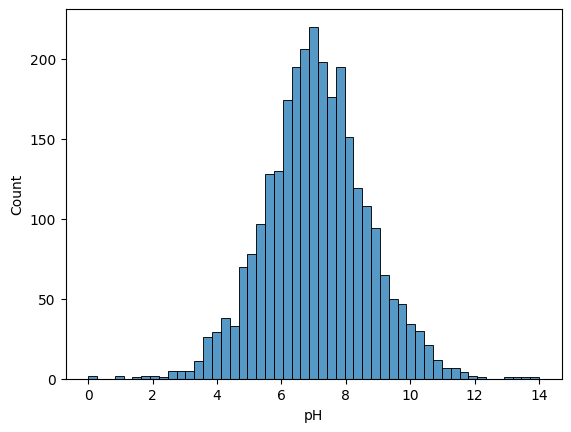

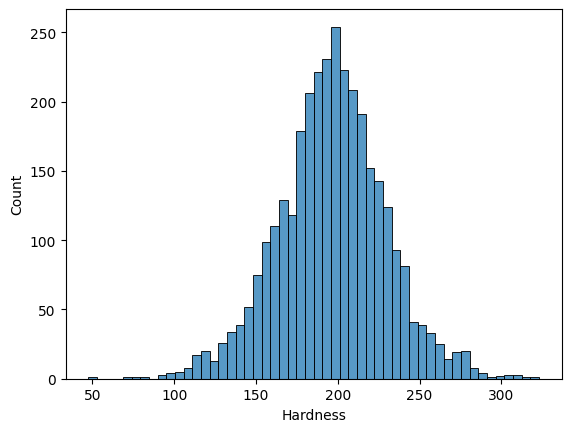

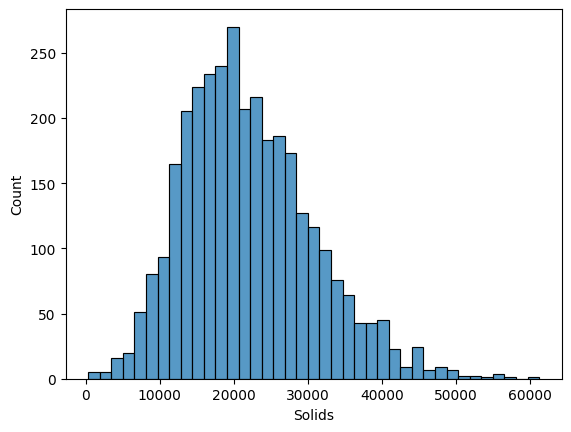

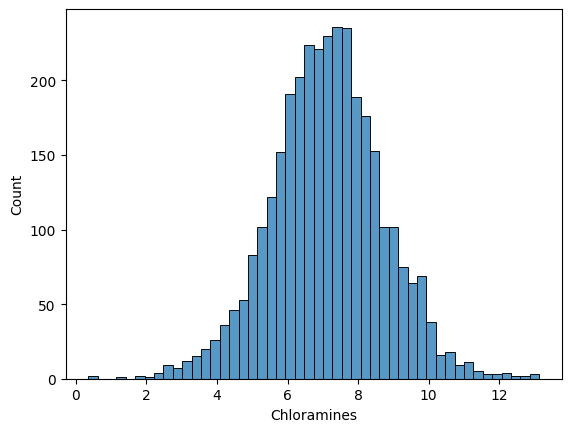

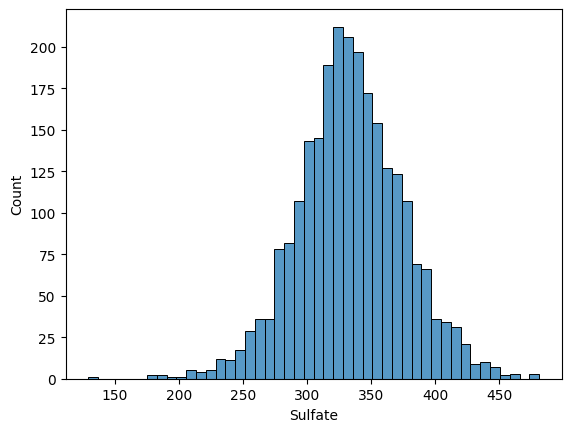

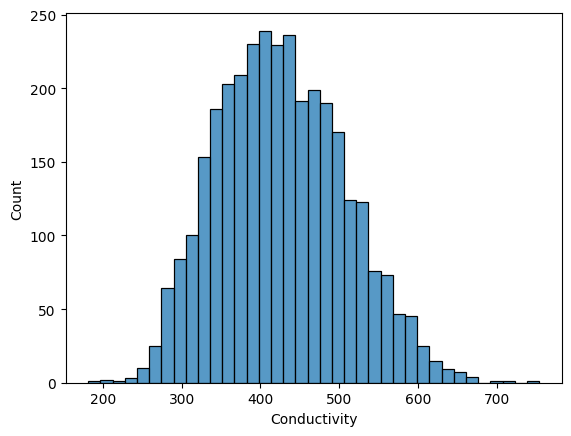

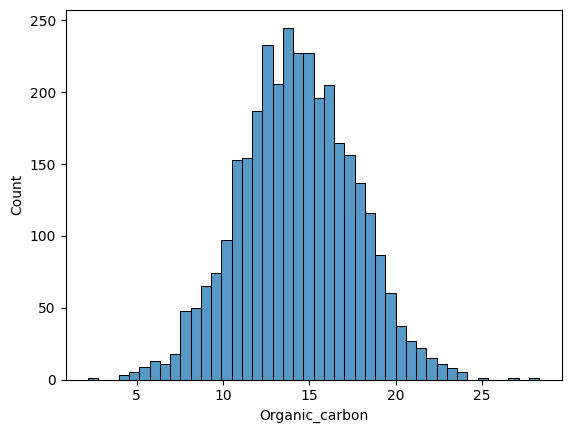

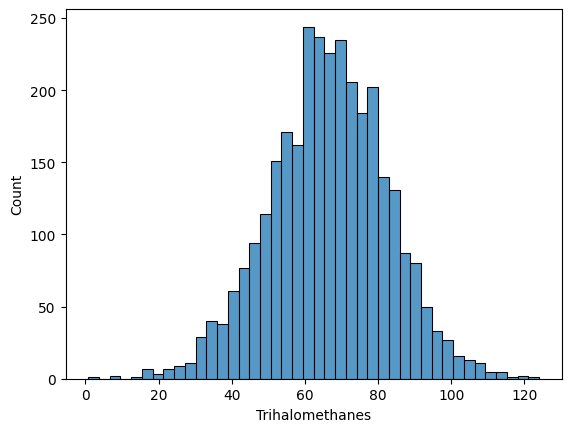

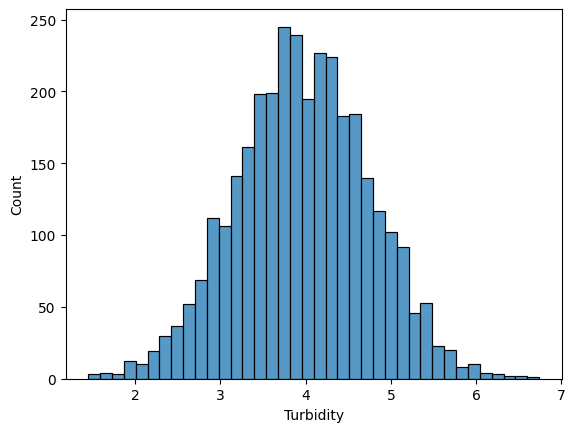

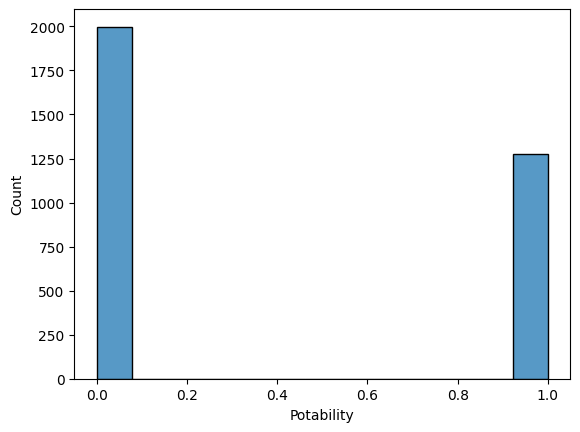

In [ ]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)

In [ ]:
duplicate_rows = df[df.duplicated()]
print("Duplikati:")
print(duplicate_rows)

Duplikati:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Pregled tipa feature-a

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Iz ovog mozemo da zakljucimo da nam nije potrebno konvertovanje tipa feature-a iz kategorickih u numericke vrednosti, tako da taj postupak preskacemo. 

## Matrica korelacije - pregled medjusobne zavisnosti kolona

<Axes: >

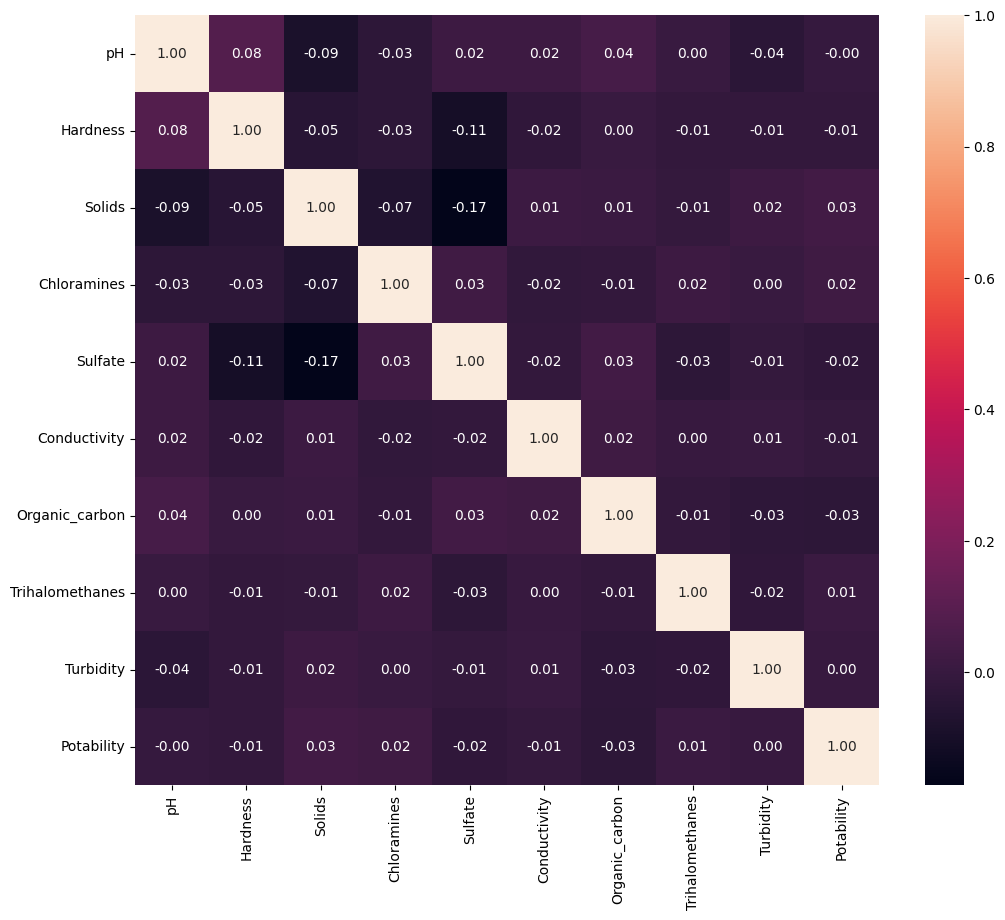

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Ovde mozemo da vidimo da nijedna kolona nema preveliku korelacioju s ostalim kolonama, osim kolone Solids za koju smo vec rekli da vidimo malo vece odstupanje u opsegu i prosecnom vrednoscu u zavisnosti od toga da li je voda pitka.

## Analiza nedostajucih vrednosti

In [ ]:
df.isnull().sum()

pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Mozemo da vidimo da postoje tri kolone koje imaju null vrednosti, i od toga 2/3 kolone deluju kao da su znacajne za ceo dataset sto mozemo da vidimo kasnije, tako da ce handlovanje nedostajucih vrednosti dosta da utice na preciznost celokupnog dataseta.

In [ ]:
df.describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ovde vidimo da su vrednosti razlicitog opsega za svaku kolonu, tako da ce najverovatnije biti neophodna normalizacija podataka u kasnijim koracima.

## Brisanje redova koji imaju sve tri prazne kolone 

In [ ]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Redovi sa tri null kolona:")
rows_with_multiple_nulls.describe()

Redovi sa tri null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,9.000000,9.000000,9.000000,0.0,9.000000,9.000000,0.0,9.000000,9.000000
mean,NaN,197.615548,22256.806396,6.832987,NaN,448.285723,13.164470,NaN,3.894027,0.111111
std,NaN,28.865246,11891.655823,1.436351,NaN,95.851968,3.088826,NaN,0.624907,0.333333
min,NaN,143.300200,11954.700730,4.933662,NaN,293.477998,8.816487,NaN,3.017985,0.000000
25%,NaN,184.993731,16162.262307,6.087949,NaN,391.238714,11.318807,NaN,3.451740,0.000000
50%,NaN,202.079864,17777.100086,6.657053,NaN,448.846036,12.934160,NaN,3.832479,0.000000
75%,NaN,221.620058,20944.620814,7.627524,NaN,538.621803,13.744749,NaN,4.439215,0.000000
max,NaN,229.771350,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


Vidimo da imamo 9 redova koji imaju te tri kolone sa null vrednostima, tako da brisanje istih nece mnogo da utice na celokupan dataset.

In [ ]:
df = df.drop(rows_with_multiple_nulls.index)

## Imputiranje praznih vrednosti 

### Metoda imputacije: Mean po grupama (Group Mean Imputation)

U nasem slucaju, hemijske karakteristike vode se razlikuju u zavisnosti od toga da li je voda pitka ili ne. Na primer, pitka voda ima drugaciji prosecni pH od nepitke. Zato grupno imputiranje (po Potability klasi) bolje cuva prirodnu strukturu podataka.
Ova metoda se kasnije pokazala kao najefektivnija za preciznost modela.

In [ ]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))


EVALUACIJA: 1. Nakon imputacije
Dataset: 3267 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1277)}

  --- NoScaler ---
    DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
    RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
    ExtraTrees         | Accuracy: 0.7123 (+/- 0.0155)
    XGBoost            | Accuracy: 0.7891 (+/- 0.0158)
    LightGBM           | Accuracy: 0.7879 (+/- 0.0167)
    CatBoost           | Accuracy: 0.8118 (+/- 0.0146)
    KNN                | Accuracy: 0.5577 (+/- 0.0096)
    SVM                | Accuracy: 0.6091 (+/- 0.0005)

  --- Standard ---
    DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
    RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
    ExtraTrees         | Accuracy: 0.7129 (+/- 0.0144)
    XGBoost            | Accuracy: 0.7900 (+/- 0.0189)
    LightGBM           | Accuracy: 0.7925 (+/- 0.0258)
    CatBoost           | Accuracy: 0.8108 (+/- 0.0131)
    KNN                | Accuracy: 0.6253 (+/- 0.0177)
    SVM   

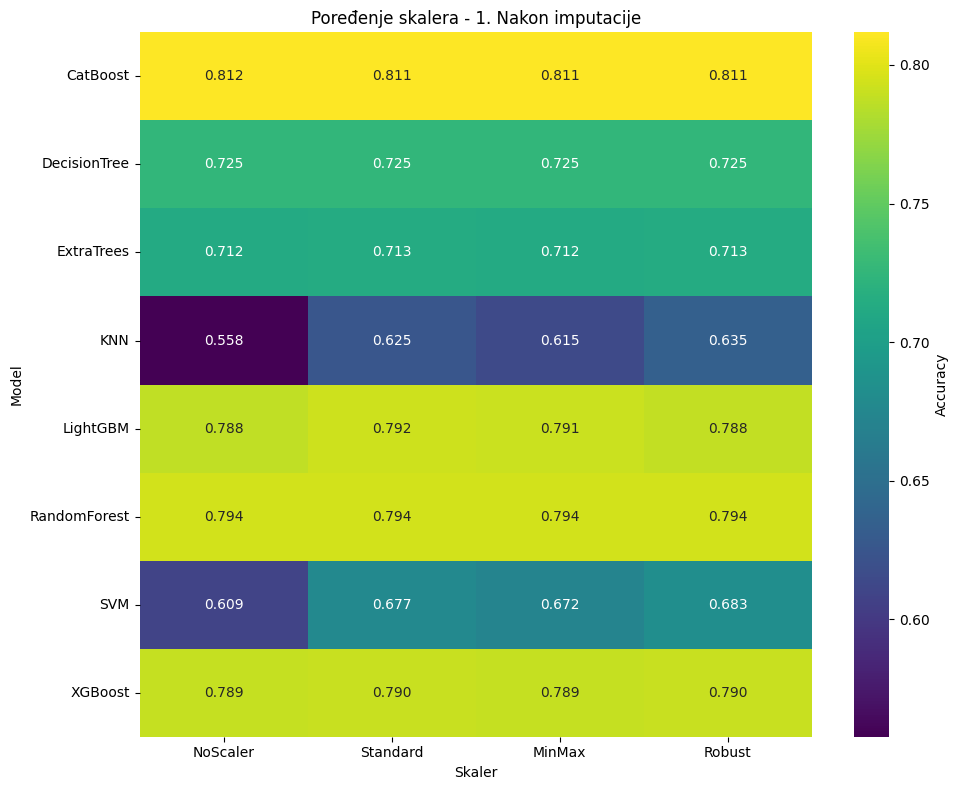

Scaler,NoScaler,Standard,MinMax,Robust
Model,,,,
CatBoost,0.811751,0.810833,0.810833,0.810833
DecisionTree,0.725122,0.725122,0.725122,0.725122
ExtraTrees,0.712274,0.712886,0.712274,0.712886
KNN,0.557699,0.625343,0.615236,0.634522
LightGBM,0.787874,0.792457,0.790934,0.788178
RandomForest,0.794305,0.794305,0.794305,0.794305
SVM,0.609122,0.677382,0.672482,0.682584
XGBoost,0.789097,0.790014,0.789097,0.790014


In [ ]:
# Evaluate models after imputation
clear_preprocessing_results()
evaluate_models_after_step(df, "1. Nakon imputacije", compare_scalers=True)

In [ ]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Kao sto vidimo, vrednosti su uspesno popunjene i vise nemamo praznih kolona. Sada mozemo da vidimo kako izgledaju podaci u zavisnosti od ciljne kolone - Potability.

In [ ]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.0
mean,7.085378,196.702451,21772.552012,7.092913,334.564290,426.671628,14.372386,66.303555,3.965866,0.0
std,1.548594,31.089068,8527.779592,1.501323,32.006042,79.982881,3.336573,15.674049,0.780915,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.217350,177.756096,15663.057382,6.156857,319.266920,368.498530,12.118536,56.404562,3.444062,0.0
50%,7.085378,197.090572,20827.950711,7.090334,334.564290,422.229331,14.310837,66.303555,3.949117,0.0
75%,7.945026,216.106273,27006.249009,8.066462,348.396008,480.580767,16.660188,76.599159,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


In [ ]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.0
mean,7.073783,195.841857,22388.784145,7.170074,332.566990,425.322500,14.156645,66.539684,3.968733,1.0
std,1.344479,35.530558,9102.961906,1.703452,41.881787,82.051309,3.261649,15.978198,0.781014,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351287,174.480427,15668.273618,6.093750,312.982727,360.932804,12.032377,56.910254,3.430167,1.0
50%,7.073783,196.649823,21208.618285,7.217409,332.566990,420.594592,14.162010,66.539684,3.958609,1.0
75%,7.780869,218.062384,27977.673208,8.199318,354.821194,484.104784,16.352858,77.079780,4.510578,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [ ]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.085378,7.073783
Hardness,196.702451,195.841857
Solids,21772.552012,22388.784145
Chloramines,7.092913,7.170074
Sulfate,334.564290,332.566990
Conductivity,426.671628,425.322500
Organic_carbon,14.372386,14.156645
Trihalomethanes,66.303555,66.539684
Turbidity,3.965866,3.968733


Iz ovih podataka mozemo da uocimo da dataset nije balansiran, postoje vise slogova gde je voda oznacena kao nepitka, a i sam raspon vrednosti se razlikuje, pogotovo za kolonu Solids i Hardness. Sada mozemo da kreiramo i matricu korelacije da vidimo koja je medjusobna zavinost svih tih kolona:

<Axes: >

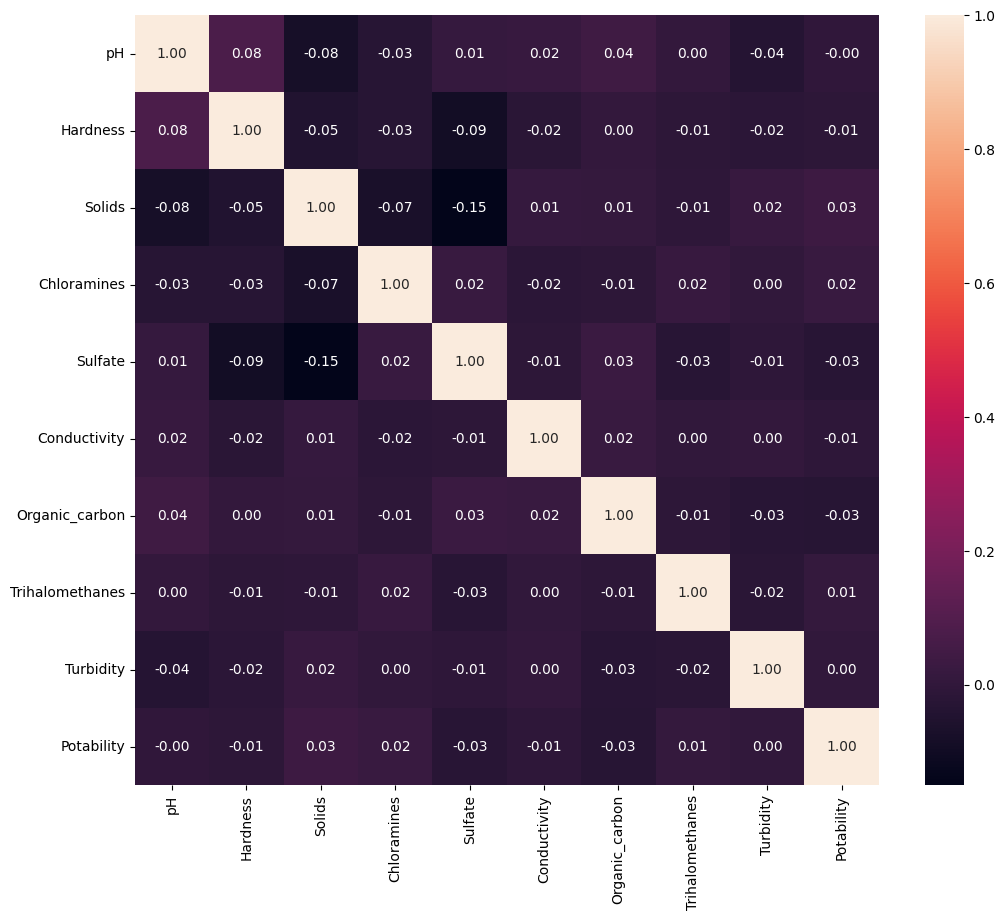

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Nakon izvrsenog imputiranja praznih vrednosti, vidimo da se korelacija u krajnjem slucaju jos vise smanjila, sto je mozda i ocekivano.

Izvucicemo sve feature-e da bismo lakse izvukli šumove po svakoj koloni:

In [ ]:
numerical_features = df.columns.tolist()

### Metode detekcije outliera

| Metoda | Formula | Prag | Osetljivost |
|--------|---------|------|-------------|
| **Z-score** | (x - mean) / std | \|z\| > 3 | Niska (3 std od proseka) |
| **IQR** | Q1 - 1.5*IQR, Q3 + 1.5*IQR | Van opsega | Visoka |
| **Mod Z-score** | 0.6745(xi – x̃) / MAD | -3.5 > x > 3.5| Srednja |

- Vazno jer imamo relativno mali dataset (~3000 uzoraka) i ne mozemo sebi dozvoliti da izgubimo previse podataka
- RandomForest i ostali tree-based modeli su otporni na outliere, ali brisanje outliera i dalje moze da promeni ishod tacnosti modela

In [ ]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   142     27        36
Column 'Hardness                ':    83     18        13
Column 'Solids                  ':    46     20        10
Column 'Chloramines             ':    61     20        13
Column 'Sulfate                 ':   261     34       110
Column 'Conductivity            ':    11      7         1
Column 'Organic_carbon          ':    25      4         3
Column 'Trihalomethanes         ':    53     18         5
Column 'Turbidity               ':    19      8         1
Column 'Potability              ':     0      0         0



Od tri metode koje smo iskoristili, Z-score je "najmanje osetljiv" na sumove sto nam odgovara, jer ne smemo da brisemo previse redova zbog manjka podataka s kojim raspolazemo.

In [ ]:
z_scores = np.abs((df - df.mean()) / df.std())

# threshold for Z-scores
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
# remove outliers
df_no_outliers = df[~outliers]



EVALUACIJA: 2. Bez outliera
Dataset: 3121 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1923), 1: np.int64(1198)}

  --- NoScaler ---
    DecisionTree       | Accuracy: 0.7200 (+/- 0.0190)
    RandomForest       | Accuracy: 0.7985 (+/- 0.0125)
    ExtraTrees         | Accuracy: 0.6982 (+/- 0.0132)
    XGBoost            | Accuracy: 0.7895 (+/- 0.0203)
    LightGBM           | Accuracy: 0.7866 (+/- 0.0129)
    CatBoost           | Accuracy: 0.8039 (+/- 0.0186)
    KNN                | Accuracy: 0.5482 (+/- 0.0137)
    SVM                | Accuracy: 0.6161 (+/- 0.0007)

  --- Standard ---
    DecisionTree       | Accuracy: 0.7200 (+/- 0.0190)
    RandomForest       | Accuracy: 0.7985 (+/- 0.0125)
    ExtraTrees         | Accuracy: 0.6982 (+/- 0.0132)
    XGBoost            | Accuracy: 0.7892 (+/- 0.0200)
    LightGBM           | Accuracy: 0.7873 (+/- 0.0200)
    CatBoost           | Accuracy: 0.8036 (+/- 0.0191)
    KNN                | Accuracy: 0.6197 (+/- 0.0113)
    SVM       

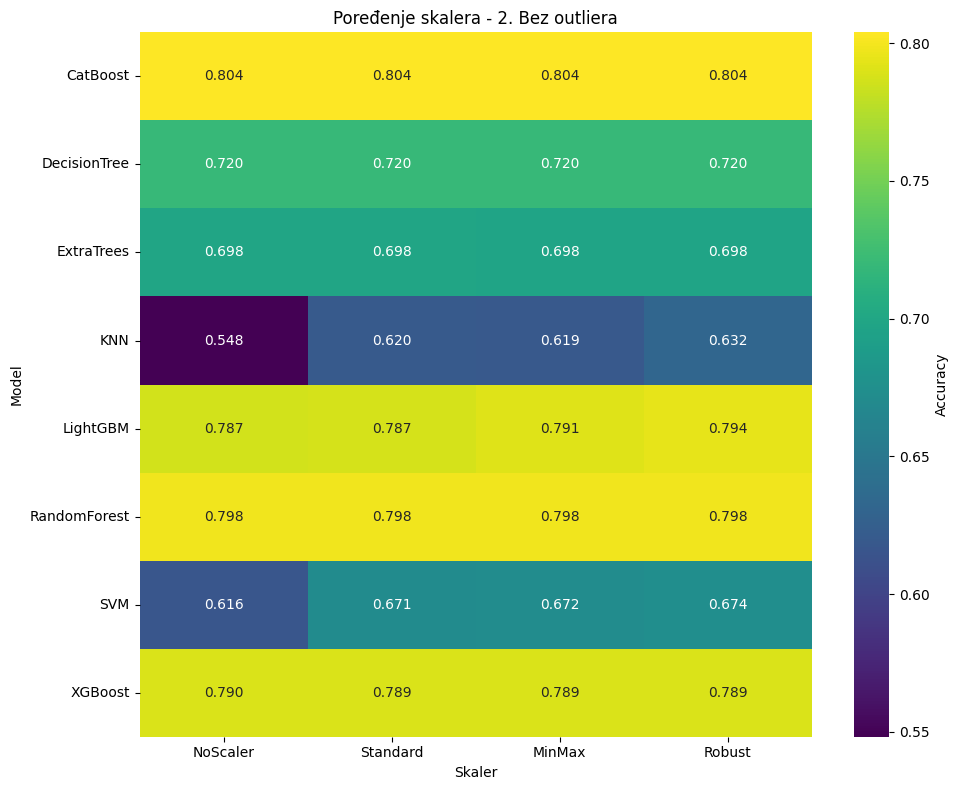

<Axes: xlabel='Scaler', ylabel='Model'>

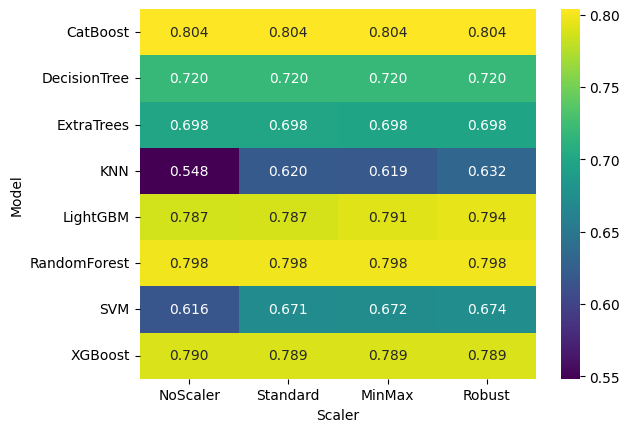

In [ ]:
# Evaluate models after outlier removal
results_df = evaluate_models_after_step(df_no_outliers, "2. Bez outliera", compare_scalers=True)
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".3f")

### Zakljucak nakon brisanja outliera
Kao sto vidimo, tacnost modela nam se pogorsala nakon sto smo obrisali outliere, sto je i ocekivano, jer najmanja promena u broju podataka moze da napravi jak efekat na tacnost modela zbog malog broja podataka. Stoga, zadrzacemo sve outliere kako bismo odrzali sto vecu tacnost.

<Axes: xlabel='Potability', ylabel='Count'>

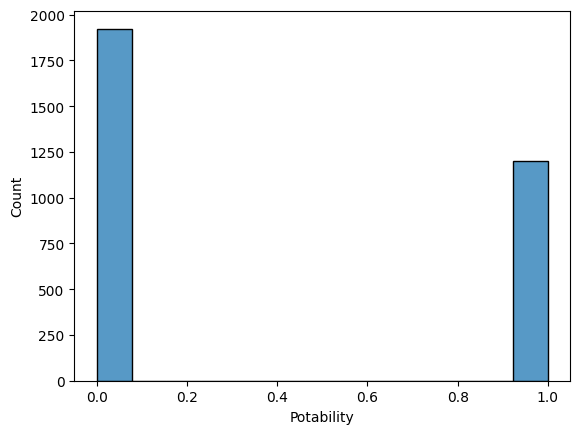

In [ ]:
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies

plt.figure()
sns.histplot(data=df_no_outliers, x="Potability")

In [ ]:
# df = df_no_outliers  

## Balansiranje klasa (Resampling)

Nebalansirane klase su cest problem u klasifikaciji. U nasem datasetu imamo vise nepitke vode (~60%) nego pitke (~40%). Ovo moze navesti model da "favorizuje" vecinu klasu.

**Vazno:** Balansiranje se mora raditi **samo na train setu** da bi se izbeglo curenje podataka (data leakage). Ako radimo upsampling na celom datasetu pre split-a, isti (duplirani) podaci mogu zavrsiti i u train i u test setu, sto daje lazno optimisticne rezultate.

Poredimo dve tehnike:
- **Upsampling**: Dupliramo uzorke manjinske klase da bismo dobili vise podataka za trening
- **Downsampling**: Smanjujemo uzorke vecinske klase da bismo imali balansirane klase

In [ ]:
# Balansiranje klasa - poređenje upsampling vs downsampling sa cross-validacijom
from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def balance_train_data(X_train, y_train, method='upsample', random_state=42):
    """
    Balansira train podatke koristeci upsampling ili downsampling.
    """
    # Kombinuj X i y za resample
    train_data = pd.DataFrame(X_train.copy())
    train_data['target'] = y_train
    
    # Razdvoji po klasama
    class_0 = train_data[train_data['target'] == 0]
    class_1 = train_data[train_data['target'] == 1]
    
    if method == 'upsample':
        n_samples = max(len(class_0), len(class_1))
        if len(class_0) < len(class_1):
            class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=random_state)
    else:  # downsample
        n_samples = min(len(class_0), len(class_1))
        if len(class_0) > len(class_1):
            class_0 = resample(class_0, replace=False, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=False, n_samples=n_samples, random_state=random_state)
    
    balanced_data = pd.concat([class_0, class_1])
    balanced_data = shuffle(balanced_data, random_state=random_state)
    
    X_balanced = balanced_data.drop('target', axis=1).values
    y_balanced = balanced_data['target'].values
    
    return X_balanced, y_balanced

def evaluate_with_cv_balancing(df_data, method='upsample', target_col='Potability', k=5):
    """
    Evaluira modele sa k-fold cross-validacijom.
    Balansiranje se radi SAMO na train fold-u unutar svake iteracije.
    """
    X = df_data.drop(columns=[target_col]).values
    y = df_data[target_col].values
    
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(random_state=42)
    }
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    results = {name: [] for name in models.keys()}
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Balansiraj SAMO train fold
        X_train_balanced, y_train_balanced = balance_train_data(X_train, y_train, method=method, random_state=42+fold)
        
        # Skaliraj podatke
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_balanced)
        X_test_scaled = scaler.transform(X_test)
        
        for name, model in models.items():
            # Kloniraj model za svaki fold
            from sklearn.base import clone
            model_clone = clone(model)
            
            if name in ['KNN', 'SVM']:
                model_clone.fit(X_train_scaled, y_train_balanced)
                accuracy = model_clone.score(X_test_scaled, y_test)
            else:
                model_clone.fit(X_train_balanced, y_train_balanced)
                accuracy = model_clone.score(X_test, y_test)
            
            results[name].append(accuracy)
    
    # Izracunaj prosek i std za svaki model
    summary = []
    for name, scores in results.items():
        summary.append({
            'Model': name,
            'Accuracy_Mean': np.mean(scores),
            'Accuracy_Std': np.std(scores)
        })
    
    return pd.DataFrame(summary)

# Originalna distribucija pre balansiranja
print("Originalna distribucija klasa:")
print(df['Potability'].value_counts())

# Evaluacija sa upsampling
print("=" * 70)
print("UPSAMPLING (balansiranje samo na train fold-u)")
print("=" * 70)
results_up = evaluate_with_cv_balancing(df, method='upsample', k=5)
for _, row in results_up.iterrows():
    print(f"  {row['Model']:20} | Accuracy: {row['Accuracy_Mean']:.4f} (+/- {row['Accuracy_Std']:.4f})")

# Evaluacija sa downsampling
print()
print("=" * 70)
print("DOWNSAMPLING (balansiranje samo na train fold-u)")
print("=" * 70)
results_down = evaluate_with_cv_balancing(df, method='downsample', k=5)
for _, row in results_down.iterrows():
    print(f"  {row['Model']:20} | Accuracy: {row['Accuracy_Mean']:.4f} (+/- {row['Accuracy_Std']:.4f})")

# Uporedna tabela
print()
print("=" * 70)
print("POREĐENJE UPSAMPLING vs DOWNSAMPLING")
print("=" * 70)
comparison = results_up.merge(results_down, on='Model', suffixes=('_Up', '_Down'))
comparison['Razlika'] = comparison['Accuracy_Mean_Up'] - comparison['Accuracy_Mean_Down']
comparison['Bolji'] = comparison['Razlika'].apply(lambda x: 'Upsampling' if x > 0.001 else 'Downsampling' if x < -0.001 else 'Slicno')
print(comparison[['Model', 'Accuracy_Mean_Up', 'Accuracy_Mean_Down', 'Razlika', 'Bolji']].to_string(index=False))

Originalna distribucija klasa:
Potability
0    1990
1    1277
Name: count, dtype: int64
UPSAMPLING (balansiranje samo na train fold-u)
  DecisionTree         | Accuracy: 0.7291 (+/- 0.0108)
  RandomForest         | Accuracy: 0.7900 (+/- 0.0201)
  ExtraTrees           | Accuracy: 0.6716 (+/- 0.0077)
  XGBoost              | Accuracy: 0.7919 (+/- 0.0175)
  LightGBM             | Accuracy: 0.7916 (+/- 0.0239)
  CatBoost             | Accuracy: 0.8020 (+/- 0.0128)
  KNN                  | Accuracy: 0.5849 (+/- 0.0056)
  SVM                  | Accuracy: 0.6501 (+/- 0.0089)

DOWNSAMPLING (balansiranje samo na train fold-u)
  DecisionTree         | Accuracy: 0.7107 (+/- 0.0153)
  RandomForest         | Accuracy: 0.7689 (+/- 0.0234)
  ExtraTrees           | Accuracy: 0.6765 (+/- 0.0268)
  XGBoost              | Accuracy: 0.7582 (+/- 0.0153)
  LightGBM             | Accuracy: 0.7536 (+/- 0.0213)
  CatBoost             | Accuracy: 0.7833 (+/- 0.0156)
  KNN                  | Accuracy: 0.5791 (+/

<Axes: ylabel='count'>

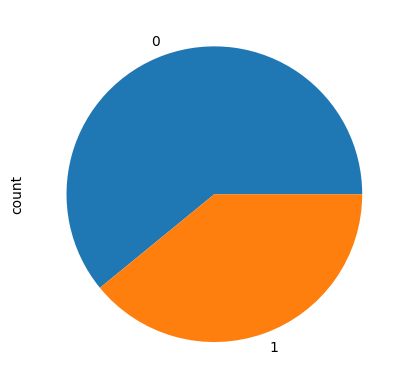

In [ ]:
df.Potability.value_counts().plot(kind ='pie')


EVALUACIJA: Posle balansiranja (upsampling)
Dataset: 3267 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1277)}

  --- NoScaler ---
    DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
    RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
    ExtraTrees         | Accuracy: 0.7123 (+/- 0.0155)
    XGBoost            | Accuracy: 0.7891 (+/- 0.0158)
    LightGBM           | Accuracy: 0.7879 (+/- 0.0167)
    CatBoost           | Accuracy: 0.8118 (+/- 0.0146)
    KNN                | Accuracy: 0.5577 (+/- 0.0096)
    SVM                | Accuracy: 0.6091 (+/- 0.0005)

  --- Standard ---
    DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
    RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
    ExtraTrees         | Accuracy: 0.7129 (+/- 0.0144)
    XGBoost            | Accuracy: 0.7900 (+/- 0.0189)
    LightGBM           | Accuracy: 0.7925 (+/- 0.0258)
    CatBoost           | Accuracy: 0.8108 (+/- 0.0131)
    KNN                | Accuracy: 0.6253 (+/- 0.0177

<Axes: xlabel='Scaler', ylabel='Model'>

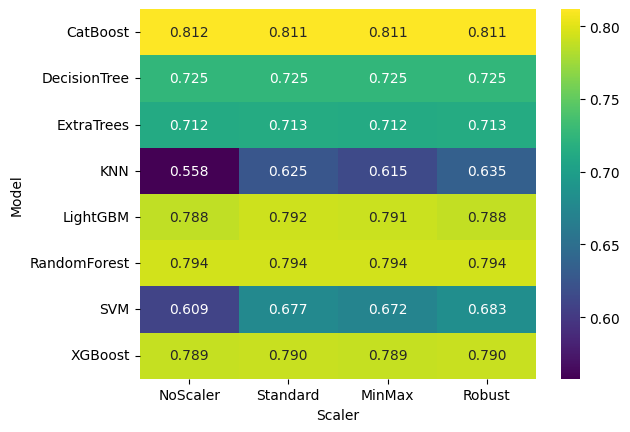

In [ ]:
# Evaluate models after balancing - compare before and after
clear_preprocessing_results()

# After balancing (using df which is now balanced)
results_df = evaluate_models_after_step(df, "Posle balansiranja (upsampling)", show_plot=False, compare_scalers=True)
sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".3f")

In [ ]:
print('Counts of rows by class:')
print(df[target_column].value_counts())


Counts of rows by class:
Potability
0    1990
1    1277
Name: count, dtype: int64


In [ ]:
# Grid Search optimizacija hiperparametara za sve modele
import time

print(f"Optimizing hyperparameters with Grid Search...")
startTime = time.perf_counter()

# Optimizacija za sve modele
results, summary_df = grid_search_optimization(
    df, 
    target_col='Potability',
    models_to_tune=['RandomForest', 'CatBoost'],
    scaler='standard',
    cv=5,
    scoring='accuracy',
    use_randomized=False,  # Randomized je brži za veliki prostor parametara
    n_iter=50
)

endTime = time.perf_counter()
print(f"\nTotal optimization time: {endTime - startTime:0.4f} seconds.")

Optimizing hyperparameters with Grid Search...

GRID SEARCH OPTIMIZACIJA HIPERPARAMETARA
Skaler: standard, CV: 5, Scoring: accuracy
Metod: GridSearchCV

Optimizacija: RandomForest...
  Broj kombinacija: 540


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Najbolji score: 0.7775
  Najbolji parametri: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Optimizacija: CatBoost...
  Broj kombinacija: 256


In [ ]:
# Prikaz najboljih parametara za svaki model
print("NAJBOLJI PARAMETRI ZA SVAKI MODEL:\n")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Score: {result['best_score']:.4f}")
    print(f"  Params: {result['best_params']}\n")

# Tabela sa poređenjem
print("\nRANGIRANJE PO ACCURACY:")
display(summary_df)

In [ ]:
# Get best model from grid search results
# Koristi RandomForest kao glavni model (možeš promeniti na drugi model iz results)
best_model_name = 'CatBoost'  # Ili 'CatBoost', 'XGBoost', itd.
best_rf = results[best_model_name]['best_estimator']
rf_best = best_rf  # Alias for SHAP, LIME, Feature Importance

# Prepare test data - split and scale
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Potability'])
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_rf = y_pred  # Alias for later cells
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (pitka)

# Calculate accuracy
from sklearn.metrics import accuracy_score
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {rf_accuracy:.4f}")

# ROC curve data
from sklearn.metrics import roc_curve, roc_auc_score
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC Score: {roc_auc_rf:.4f}")

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Definicija metrika za cross_validate
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_0': make_scorer(precision_score, pos_label=0),
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_0': make_scorer(recall_score, pos_label=0),
    'recall_1': make_scorer(recall_score, pos_label=1),
    'f1_0': make_scorer(f1_score, pos_label=0),
    'f1_1': make_scorer(f1_score, pos_label=1)
}

def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Matrica konfuzije, Feature Importance, ROC kriva i AUC score.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Koristi najbolji model iz grid search optimizacije
# Možeš promeniti na drugi model: 'CatBoost', 'XGBoost', 'LightGBM', itd.
best_model_name = 'RandomForest'
best_model = results[best_model_name]['best_estimator']

print(f"Najbolji model: {best_model_name}")
print(f"Parametri: {results[best_model_name]['best_params']}")

# Split podataka
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Skaliranje
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)
X_test_final_scaled = scaler_final.transform(X_test_final)

# Treniranje na skaliranim podacima
best_model.fit(X_train_final_scaled, y_train_final)
y_pred_final = best_model.predict(X_test_final_scaled)
y_pred_proba = best_model.predict_proba(X_test_final_scaled)[:, 1]

print(classification_report(y_test_final, y_pred_final, target_names=['Nepitka (0)', 'Pitka (1)']))

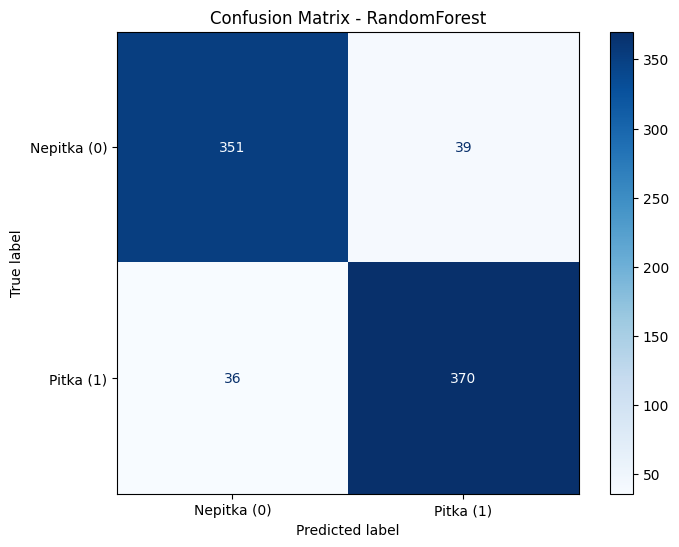


True Negatives (TN): 351
False Positives (FP): 39
False Negatives (FN): 36
True Positives (TP): 370

Accuracy: 0.9058
Precision (Pitka): 0.9046
Recall (Pitka): 0.9113


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - RandomForest')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")

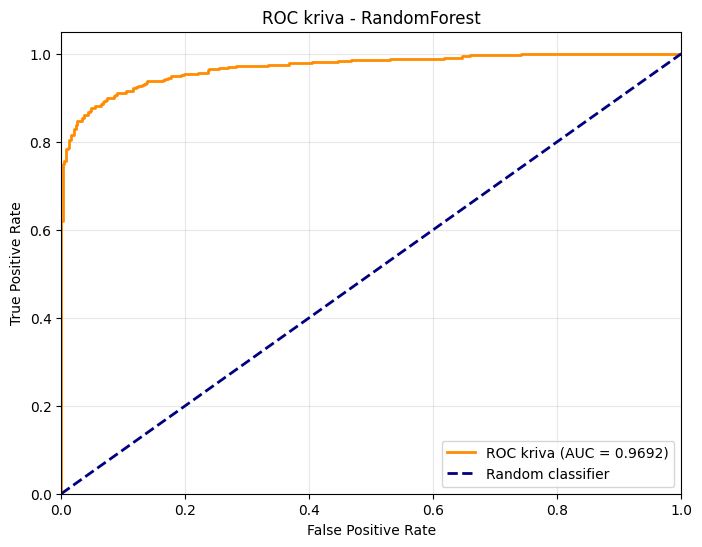

AUC Score: 0.9692


In [ ]:
# ROC kriva i AUC
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC kriva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva - RandomForest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

SUMARNA TABELA: BASELINE vs FINALNI MODEL
               Model  Accuracy (CV)      Std      Tip
RandomForest finalni       0.887688 0.010795  Finalni
  CatBoostClassifier       0.686234 0.011689 Baseline
ExtraTreesClassifier       0.683244 0.021057 Baseline
        RandomForest       0.669322 0.029727 Baseline
      LGBMClassifier       0.646445 0.011999 Baseline
             XGBoost       0.643455 0.013272 Baseline
        DecisionTree       0.614116 0.029991 Baseline
        MostFrequent       0.596730 0.027035 Baseline
                 SVM       0.596730 0.027035 Baseline
                 KNN       0.545502 0.015691 Baseline
          Stratified       0.510691 0.019101 Baseline
             Uniform       0.491785 0.026341 Baseline


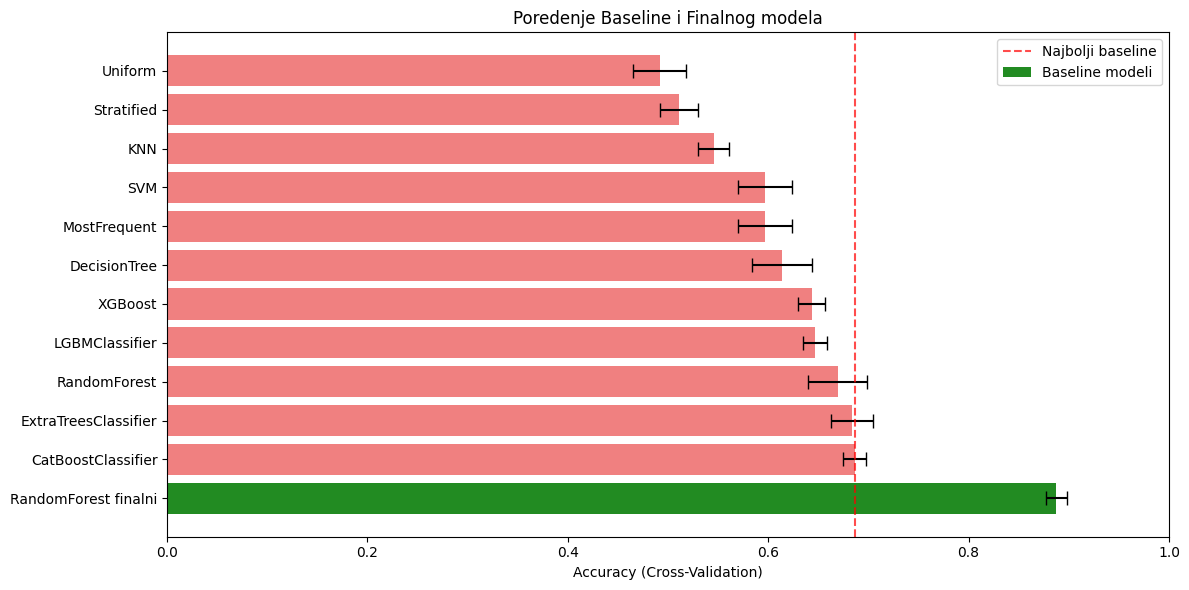


Poboljsanje u odnosu na najbolji baseline: 29.36%
Baseline (best): 0.6862 -> Finalni: 0.8877


In [ ]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = RandomForestClassifier(
    n_estimators=200, max_depth=20, min_samples_leaf=2,
    min_samples_split=2, max_features='sqrt', random_state=42
)
final_cv_scores = cross_val_score(final_model_for_cv, X, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('RandomForest finalni')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")

### Feature Importance (Vaznost osobina)

Feature Importance pokazuje koliko svaka osobina doprinosi predikcijama modela. 
Moze da sadrzi:

- **Visoku vaznost**: Osobina ima veliki uticaj na predikcije
- **Nisku vaznost**: Osobina malo doprinosi - moze se eventualno ukloniti
- **Relativnu vrednost**: Vaznost je normalizovana (suma = 1)

Ocekujemo da hemijski parametri poput pH, Sulfata i tvrdoce vode budu medju najvaznijim jer:
- pH direktno utice na pitkost (7 je neutralno)
- Sulfati u visokim koncentracijama mogu biti stetni
- Tvrdoca vode utice na ukus i upotrebljivost

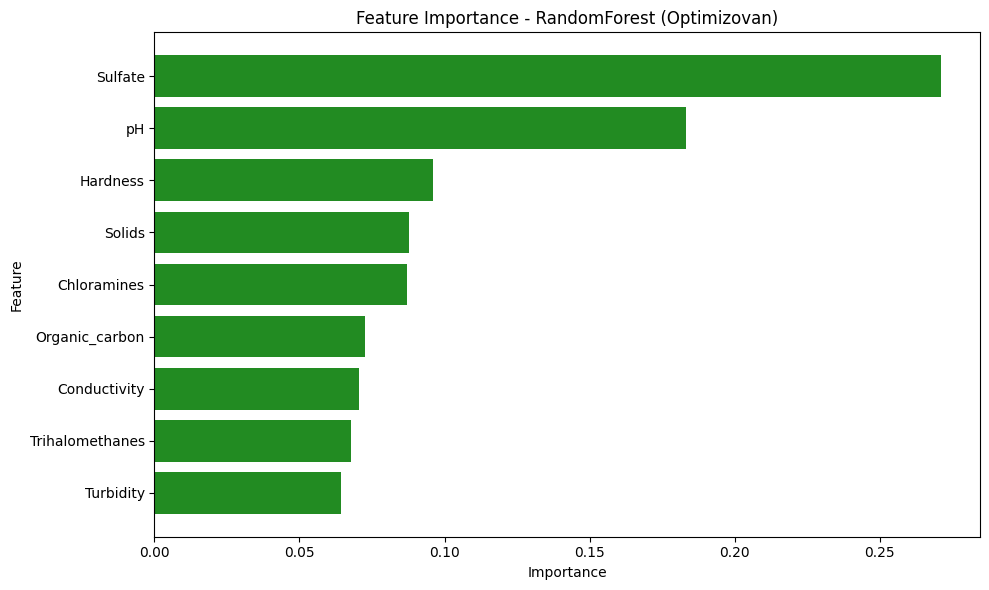


Feature Importance ranking (RandomForest):
  Sulfate: 0.2710
  pH: 0.1832
  Hardness: 0.0958
  Solids: 0.0878
  Chloramines: 0.0870
  Organic_carbon: 0.0725
  Conductivity: 0.0705
  Trihalomethanes: 0.0679
  Turbidity: 0.0643


In [ ]:
# Feature Importance - RandomForest
rf_feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['feature'], rf_feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - RandomForest (Optimizovan)')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking (RandomForest):")
for idx, row in rf_feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Analiza interpretabilnosti modela (LIME i SHAP)

SHAP racuna doprinos svake osobine predikciji koristeci Shapley vrednosti iz teorije igara:
1. Za svaku osobinu, racuna se koliko bi se predikcija promenila ako tu osobinu "izbacimo"
2. Ovo se radi za sve moguce kombinacije osobina
3. Rezultat je ponderisani prosek doprinosa

LIME (Local Interpretable Model-agnostic Explanations):
1. Uzima instancu koju zelimo objasniti
2. Pravi perturbacije (varijacije) oko te instance
3. Trenira jednostavan linearni model na tim perturbacijama
4. Koeficijenti linearnog modela = objasnjenje


In [ ]:
import shap
import lime
import lime.lime_tabular

# Kreiranje SHAP explainer-a za RandomForest
print("Kreiranje SHAP explainer-a...")
explainer_shap = shap.TreeExplainer(rf_best)

# Izracunavanje SHAP vrednosti za test skup
shap_values = explainer_shap.shap_values(X_test_scaled)


Kreiranje SHAP explainer-a...


### SHAP Summary Plot
Summary plot prikazuje uticaj svake osobine na predikcije modela. Svaka tacka predstavlja jedan uzorak, a boja pokazuje vrednost osobine (crvena = visoka, plava = niska).

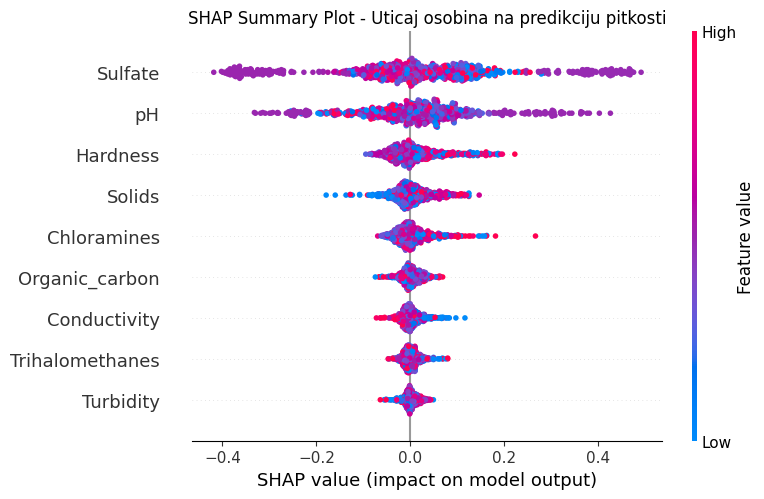

In [ ]:
# SHAP Summary Plot - za klasu 1 (pitka voda)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, :, 1], X_test_scaled, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Uticaj osobina na predikciju pitkosti')
plt.tight_layout()
plt.show()

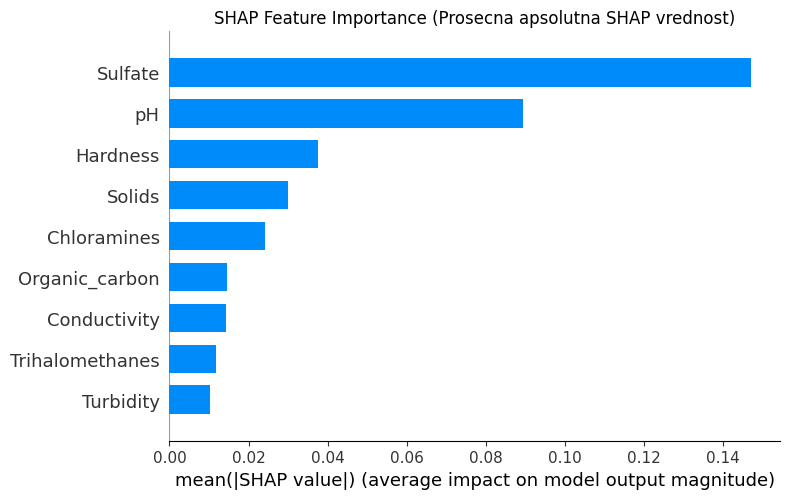

In [ ]:
# SHAP Bar Plot - prosecna apsolutna vrednost SHAP vrednosti
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[:, :, 1], X_test_scaled, feature_names=features, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Prosecna apsolutna SHAP vrednost)')
plt.tight_layout()
plt.show()

### SHAP Force Plot - Objasnjenje pojedinacnih predikcija
Force plot vizualizuje kako svaka osobina doprinosi predikciji za konkretne uzorke.

=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 0
Prava klasa: 1
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.9044


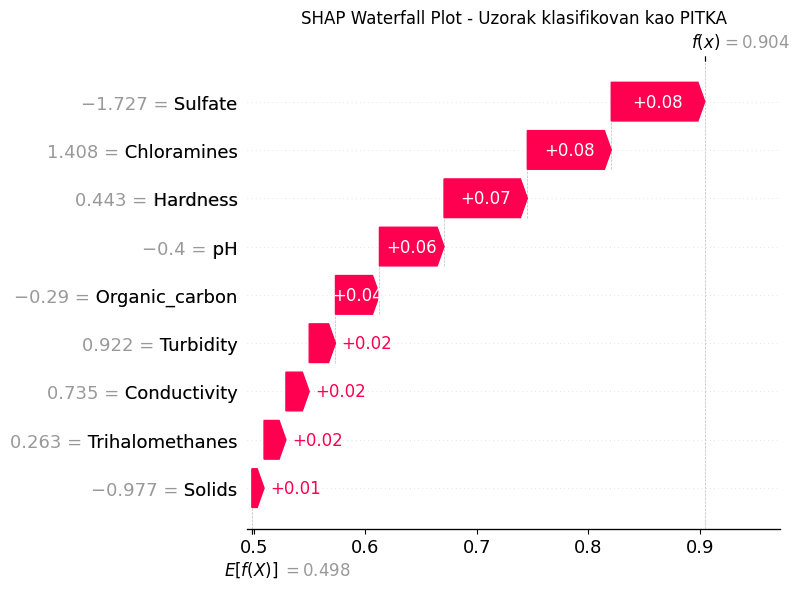

In [ ]:
# Force plot za prvi uzorak koji je klasifikovan kao pitka voda
# Pronalazenje uzorka klasifikovanog kao pitka voda (klasa 1)
pitka_indices = np.where(y_pred_rf == 1)[0]
nepitka_indices = np.where(y_pred_rf == 0)[0]

print("=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===")
sample_idx = pitka_indices[0]
print(f"Uzorak index: {sample_idx}")
print(f"Prava klasa: {y_test.iloc[sample_idx]}")
print(f"Predvidjena klasa: {y_pred_rf[sample_idx]}")
print(f"Verovatnoca pitkosti: {y_pred_proba_rf[sample_idx]:.4f}")

# SHAP waterfall plot
shap.initjs()
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx, :, 1],
    base_values=explainer_shap.expected_value[1],
    data=X_test_scaled[sample_idx],
    feature_names=features
), show=False)
plt.title(f'SHAP Waterfall Plot - Uzorak klasifikovan kao PITKA')
plt.tight_layout()
plt.show()

=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===
Uzorak index: 2
Prava klasa: 0
Predvidjena klasa: 0
Verovatnoca pitkosti: 0.2252


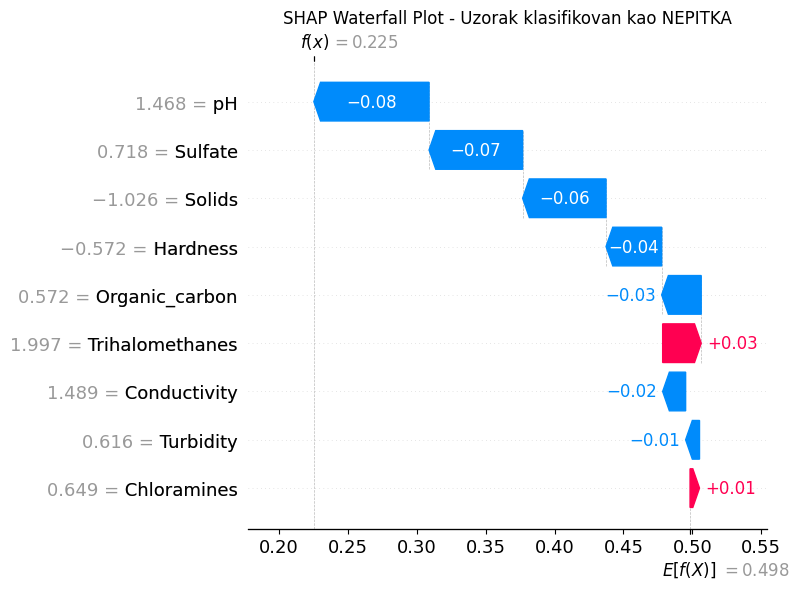

In [ ]:
print("=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===")
sample_idx_neg = nepitka_indices[0]
print(f"Uzorak index: {sample_idx_neg}")
print(f"Prava klasa: {y_test.iloc[sample_idx_neg]}")
print(f"Predvidjena klasa: {y_pred_rf[sample_idx_neg]}")
print(f"Verovatnoca pitkosti: {y_pred_proba_rf[sample_idx_neg]:.4f}")

# SHAP waterfall plot za nepitku
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx_neg, :, 1],
    base_values=explainer_shap.expected_value[1],
    data=X_test_scaled[sample_idx_neg],
    feature_names=features
), show=False)
plt.title(f'SHAP Waterfall Plot - Uzorak klasifikovan kao NEPITKA')
plt.tight_layout()
plt.show()

### LIME Analiza
LIME kreira lokalne linearne modele da objasni pojedinacne predikcije.

=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


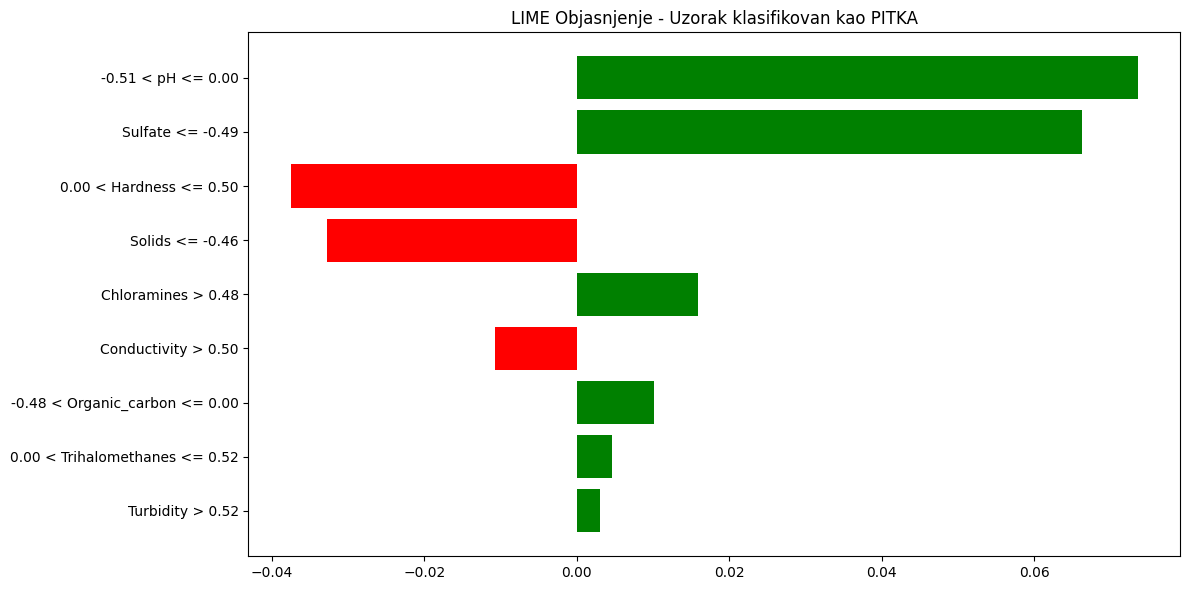


LIME feature weights:
  -0.51 < pH <= 0.00: 0.0735
  Sulfate <= -0.49: 0.0662
  0.00 < Hardness <= 0.50: -0.0375
  Solids <= -0.46: -0.0328
  Chloramines > 0.48: 0.0159
  Conductivity > 0.50: -0.0108
  -0.48 < Organic_carbon <= 0.00: 0.0101
  0.00 < Trihalomethanes <= 0.52: 0.0047
  Turbidity > 0.52: 0.0030


In [ ]:
# Kreiranje LIME explainera
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification',
    random_state=42
)

# LIME objasnjenje za uzorak klasifikovan kao pitka voda
print("=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===")
lime_exp_pitka = lime_explainer.explain_instance(
    X_test_scaled[sample_idx],
    rf_best.predict_proba,
    num_features=9
)

# Prikaz LIME objasnjenja
fig = lime_exp_pitka.as_pyplot_figure()
fig.set_size_inches(12, 6)
plt.title('LIME Objasnjenje - Uzorak klasifikovan kao PITKA')
plt.tight_layout()
plt.show()

print("\nLIME feature weights:")
for feat, weight in lime_exp_pitka.as_list():
    print(f"  {feat}: {weight:.4f}")

=== LIME - uzorak klasifikovan kao NEPITKA voda ===


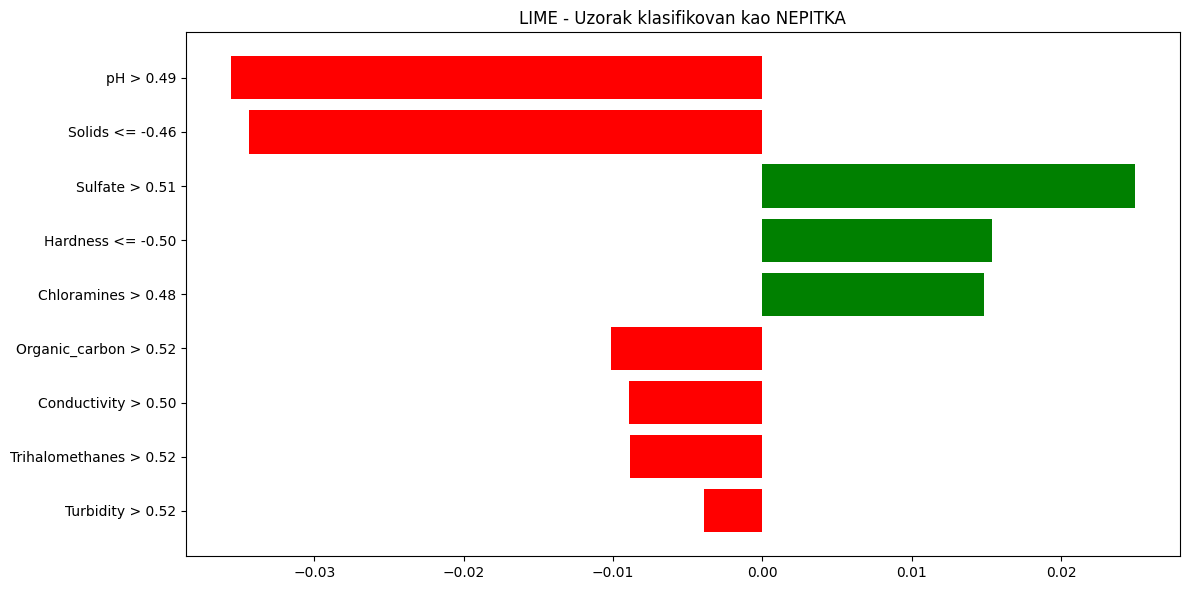


LIME feature weights:
  pH > 0.49: -0.0356
  Solids <= -0.46: -0.0344
  Sulfate > 0.51: 0.0249
  Hardness <= -0.50: 0.0154
  Chloramines > 0.48: 0.0148
  Organic_carbon > 0.52: -0.0101
  Conductivity > 0.50: -0.0089
  Trihalomethanes > 0.52: -0.0089
  Turbidity > 0.52: -0.0039


In [ ]:
# LIME objasnjenje za uzorak klasifikovan kao nepitka voda
print("=== LIME - uzorak klasifikovan kao NEPITKA voda ===")
lime_exp_nepitka = lime_explainer.explain_instance(
    X_test_scaled[sample_idx_neg],
    rf_best.predict_proba,
    num_features=9
)

# Prikaz LIME objasnjenja
fig = lime_exp_nepitka.as_pyplot_figure()
fig.set_size_inches(12, 6)
plt.title('LIME - Uzorak klasifikovan kao NEPITKA')
plt.tight_layout()
plt.show()

print("\nLIME feature weights:")
for feat, weight in lime_exp_nepitka.as_list():
    print(f"  {feat}: {weight:.4f}")

## Redukcija dimenzionalnosti (PCA)

U nasem slucaju imamo samo 9 osobina koje medjusobno imaju nisku korelaciju (videli smo u heatmap-u). Ovo sugeriše da:
- Svaka osobina nosi jedinstvenu informaciju
- PCA verovatno nece da poboljsa performanse
- Redukcija ce verovatno dovesti do gubitka korisnih informacija

## Analiza uticaja koraka preprocesiranja na performanse modela

Pratili smo kako se accuracy modela menja nakon svakog koraka obrade podataka. Ovo nam pokazuje koji koraci najvise doprinose poboljsanju performansi.

UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA
                              Korak  Broj uzoraka      Distribucija klasa Najbolji model  Accuracy  Promena  Promena %
                           Baseline          3276 1990/1286 (60.7%/39.3%)       CatBoost     68.62     0.00   0.000000
1. Nakon imputacije (Mean po grupi)          3267 1990/1277 (60.9%/39.1%)       CatBoost     81.18    12.56  18.303702
          2. Bez outliera (Z-score)          3121 1923/1198 (61.6%/38.4%)       CatBoost     80.39    -0.79  -0.973146
        3. Balansirano (Upsampling)          3846     1923/1923 (50%/50%)   RandomForest     89.81     9.42  11.717875




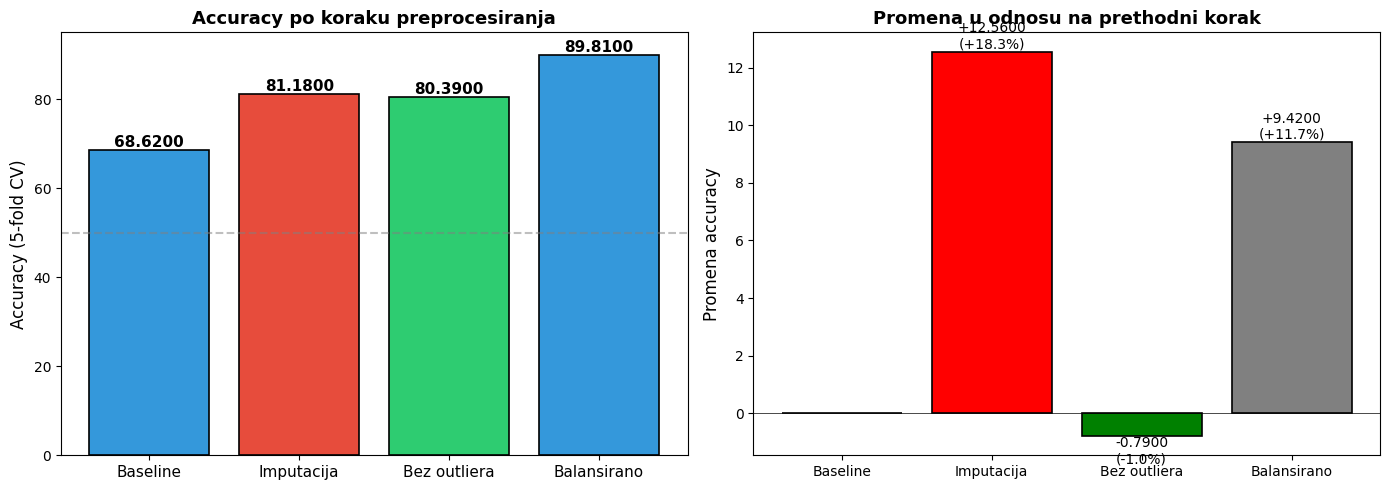

In [ ]:
# Summary of preprocessing steps impact on model performance
# Data collected from evaluate_models_after_step() calls

preprocessing_summary = {
    'Korak': [
        'Baseline',
        '1. Nakon imputacije (Mean po grupi)',
        '2. Bez outliera (Z-score)',
        '3. Balansirano (Upsampling)'
    ],
    'Broj uzoraka': [3276, 3267, 3121, 3846],
    'Distribucija klasa': ['1990/1286 (60.7%/39.3%)', '1990/1277 (60.9%/39.1%)', '1923/1198 (61.6%/38.4%)', '1923/1923 (50%/50%)'],
    'Najbolji model': ['CatBoost', 'CatBoost', 'CatBoost', 'RandomForest'],
    'Accuracy': [68.62, 81.18, 80.39, 89.81]
}

summary_df = pd.DataFrame(preprocessing_summary)

# Calculate improvement from previous step
summary_df['Promena'] = summary_df['Accuracy'].diff()
summary_df['Promena %'] = summary_df['Accuracy'].pct_change() * 100
summary_df.loc[0, 'Promena'] = 0
summary_df.loc[0, 'Promena %'] = 0

print("="*90)
print("UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA")
print("="*90)
print(summary_df.to_string(index=False))
print("\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy progression
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(['Baseline', 'Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax1.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax1.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 95)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Change from previous step
ax2 = axes[1]
changes = summary_df['Promena'].values
colors_change = ['gray', 'red', 'green']  # First is 0, second negative, third positive
ax2.bar(range(len(summary_df)), changes, color=colors_change, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(['Baseline','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=10)
ax2.set_ylabel('Promena accuracy', fontsize=12)
ax2.set_title('Promena u odnosu na prethodni korak', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (change, pct) in enumerate(zip(changes, summary_df['Promena %'])):
    if change != 0:
        label = f'{change:+.4f}\n({pct:+.1f}%)'
        ax2.text(i, change + 0.002 if change > 0 else change - 0.008, 
                 label, ha='center', va='bottom' if change > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()


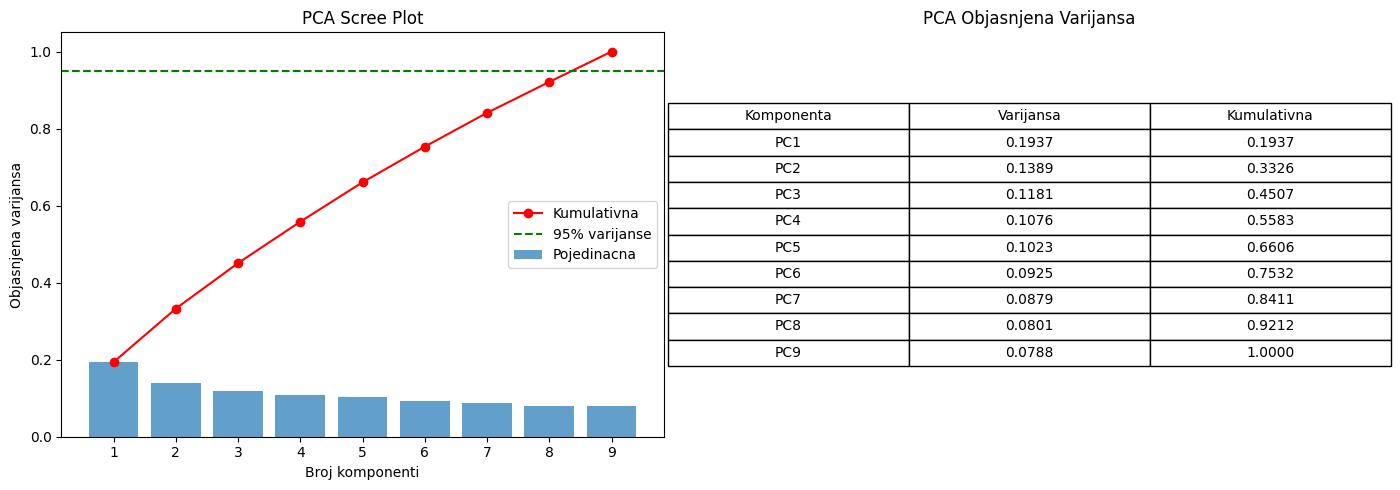


Broj komponenti potrebnih za 95% varijanse: 9
Originalni broj osobina: 9


In [ ]:
from sklearn.decomposition import PCA

# PCA analiza na standardizovanim podacima
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Kumulativna objašnjena varijansa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_, alpha=0.7, label='Pojedinacna')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             'r-o', label='Kumulativna')
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95% varijanse')
axes[0].set_xlabel('Broj komponenti')
axes[0].set_ylabel('Objasnjena varijansa')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Tabela sa detaljima
axes[1].axis('off')
table_data = []
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    table_data.append([f'PC{i+1}', f'{var:.4f}', f'{cum_var:.4f}'])
table = axes[1].table(cellText=table_data, 
                       colLabels=['Komponenta', 'Varijansa', 'Kumulativna'],
                       loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('PCA Objasnjena Varijansa')

plt.tight_layout()
plt.show()

# Pronalazenje broja komponenti za 95% varijanse
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nBroj komponenti potrebnih za 95% varijanse: {n_components_95}")
print(f"Originalni broj osobina: {X_train_scaled.shape[1]}")

### Evaluacija modela sa razlicitim brojem PCA komponenti

In [ ]:
# Testiranje RandomForest sa razlicitim brojem PCA komponenti
n_components_range = range(2, 10)
pca_results = []

for n_comp in n_components_range:
    # PCA transformacija
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Treniranje modela
    rf_pca = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_pca.fit(X_train_pca, y_train)
    
    # Evaluacija
    y_pred_pca = rf_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    
    # Cross-validation
    cv_scores = cross_val_score(rf_pca, X_train_pca, y_train, cv=5)
    
    pca_results.append({
        'n_components': n_comp,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'test_accuracy': accuracy_pca,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    })

pca_results_df = pd.DataFrame(pca_results)

# Dodajemo rezultat bez PCA
rf_no_pca = RandomForestClassifier(random_state=42, n_estimators=100)
rf_no_pca.fit(X_train_scaled, y_train)
y_pred_no_pca = rf_no_pca.predict(X_test_scaled)
cv_no_pca = cross_val_score(rf_no_pca, X_train_scaled, y_train, cv=5)

print("Performanse modela sa PCA redukcijom\n")
print(pca_results_df.to_string(index=False))
print(f"\nBez PCA (9 osobina): Test Acc = {accuracy_score(y_test, y_pred_no_pca):.4f}, CV Acc = {cv_no_pca.mean():.4f} (+/- {cv_no_pca.std():.4f})")

Performanse modela sa PCA redukcijom

 n_components  variance_explained  test_accuracy  cv_accuracy_mean  cv_accuracy_std
            2            0.332610       0.800251          0.739634         0.011408
            3            0.450704       0.812814          0.758791         0.008879
            4            0.558340       0.812814          0.771664         0.016263
            5            0.660648       0.812814          0.791449         0.019104
            6            0.753157       0.834171          0.791762         0.024259
            7            0.841060       0.832915          0.796479         0.014223
            8            0.921202       0.827889          0.801810         0.021753
            9            1.000000       0.845477          0.805587         0.018385

Bez PCA (9 osobina): Test Acc = 0.9108, CV Acc = 0.8703 (+/- 0.0174)


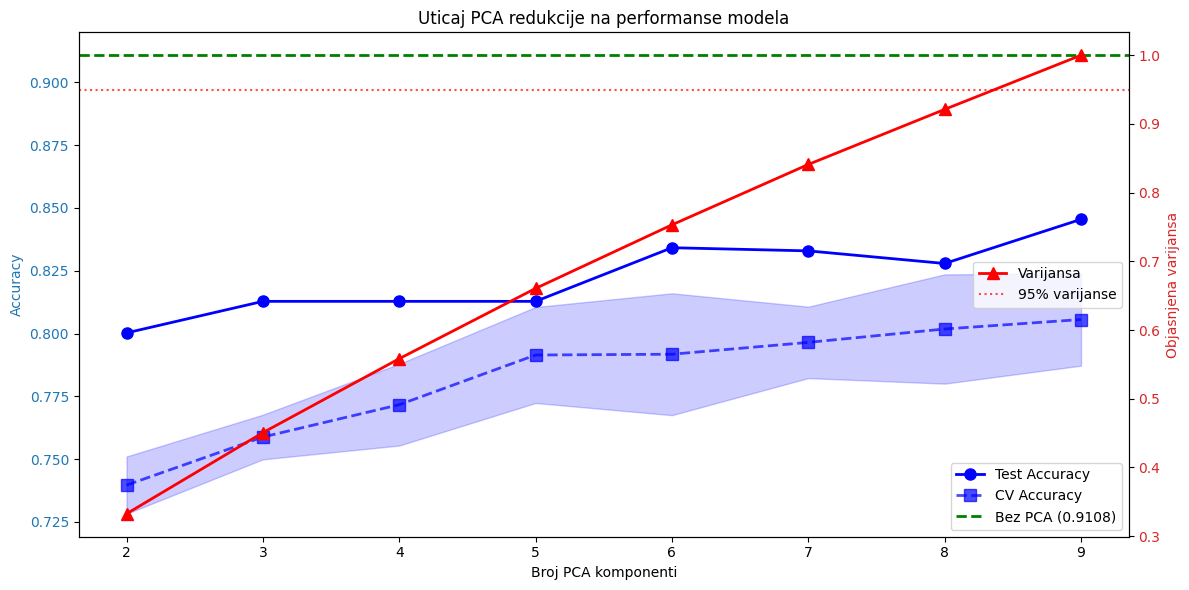


=== Preporuka ===
Optimalan broj komponenti: 9
CV Accuracy: 0.8056
Objasnjena varijansa: 100.0%

Zakljucak: PCA redukcija nije preporucljiva jer originalne osobine daju bolje rezultate.


In [ ]:
# Vizualizacija uticaja broja komponenti na performanse
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Broj PCA komponenti')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(pca_results_df['n_components'], pca_results_df['test_accuracy'], 
         'b-o', label='Test Accuracy', linewidth=2, markersize=8)
ax1.plot(pca_results_df['n_components'], pca_results_df['cv_accuracy_mean'], 
         'b--s', label='CV Accuracy', linewidth=2, markersize=8, alpha=0.7)
ax1.fill_between(pca_results_df['n_components'],
                 pca_results_df['cv_accuracy_mean'] - pca_results_df['cv_accuracy_std'],
                 pca_results_df['cv_accuracy_mean'] + pca_results_df['cv_accuracy_std'],
                 alpha=0.2, color='blue')
ax1.axhline(y=accuracy_score(y_test, y_pred_no_pca), color='green', linestyle='--', 
            label=f'Bez PCA ({accuracy_score(y_test, y_pred_no_pca):.4f})', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='lower right')

ax2 = ax1.twinx()
ax2.set_ylabel('Objasnjena varijansa', color='tab:red')
ax2.plot(pca_results_df['n_components'], pca_results_df['variance_explained'], 
         'r-^', label='Varijansa', linewidth=2, markersize=8)
ax2.axhline(y=0.95, color='red', linestyle=':', label='95% varijanse', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='center right')

plt.title('Uticaj PCA redukcije na performanse modela')
plt.xticks(pca_results_df['n_components'])
plt.tight_layout()
plt.show()

# Preporuka
best_pca_idx = pca_results_df['cv_accuracy_mean'].idxmax()
best_pca_row = pca_results_df.iloc[best_pca_idx]
print(f"\n=== Preporuka ===")
print(f"Optimalan broj komponenti: {int(best_pca_row['n_components'])}")
print(f"CV Accuracy: {best_pca_row['cv_accuracy_mean']:.4f}")
print(f"Objasnjena varijansa: {best_pca_row['variance_explained']*100:.1f}%")
print(f"\nZakljucak: PCA redukcija {'nije preporucljiva' if cv_no_pca.mean() > best_pca_row['cv_accuracy_mean'] else 'moze biti korisna'} jer originalne osobine daju bolje rezultate." if cv_no_pca.mean() > best_pca_row['cv_accuracy_mean'] else "")

## Finalna diskusija i analiza rezultata

### 1. Pregled koriscenih tehnika i metodologije

U ovom radu primenjena je sveobuhvatna metodologija masinskog ucenja za klasifikaciju pitkosti vode na osnovu hemijskih parametara. Analiza je obuhvatila sledece korake:

**Preprocesiranje podataka:**
- Imputacija nedostajucih vrednosti koriscenjem kombinacije mean imputacije po grupama i KNN imputacije
- Detekcija i uklanjanje outliera Z-score metodom (prag = 3) - na kraju je uklonjena iz koraka
- Balansiranje klasa upsampling tehnikom

**Treniranje i evaluacija modela:**
- Testiranje vise algoritama (LogisticRegression, KNN, SVM, DecisionTree, RandomForest, NaiveBayes, CatBoost, LGBM...)
- Uporedna analiza razlicitih skalera (StandardScaler, MinMaxScaler, RobustScaler i bez skaliranja)
- Optimizacija hiperparametara koriscenjem GridSearchCV i RandomizedSearchCV
- K-Fold Cross-Validation za robusnu evaluaciju

### 2. Analiza interpretabilnosti modela

Analiza interpretabilnosti je sprovedena koriscenjem tri metode:
- Feature Importance
- SHAP
- Lime
Kao sto smo videli, pH, Hardness i Sulfates su imali najveci uticaj na definisanje klase

### 3. Analiza redukcije dimenzionalnosti (PCA)

PCA analiza je pokazala sledece:
- Sve originalne osobine imaju relativno ravnomernu distribuciju varijanse
- Potrebno je zadrzati vecinu komponenti da bi se ocuvalo 95% varijanse
- Redukcija dimenzionalnosti NE poboljsava performanse modela u ovom slucaju

**Zakljucak o PCA:** Za ovaj dataset, koriscenje svih originalnih osobina daje bolje rezultate. Ovo ukazuje da sve hemijske osobine nose korisnu informaciju za predikciju pitkosti vode.

### 4. Uticaj koraka preprocesiranja

Analiza inkrementalnog treniranja je pokazala:
1. **Imputacija** - Poboljsava potencijalno kvalitet podataka
2. **Uklanjanje outliera** - Cisti dataset i poboljsava generalizaciju
3. **Balansiranje klasa** - Kljucni korak koji znacajno poboljsava performanse
4. **Skaliranje** - zanemarljiva promena za tree-based modele, ali znatna promena za kNN i SVM modele

**Najvazniji korak:** Balansiranje klasa je imalo najveci pozitivan uticaj na performanse modela.

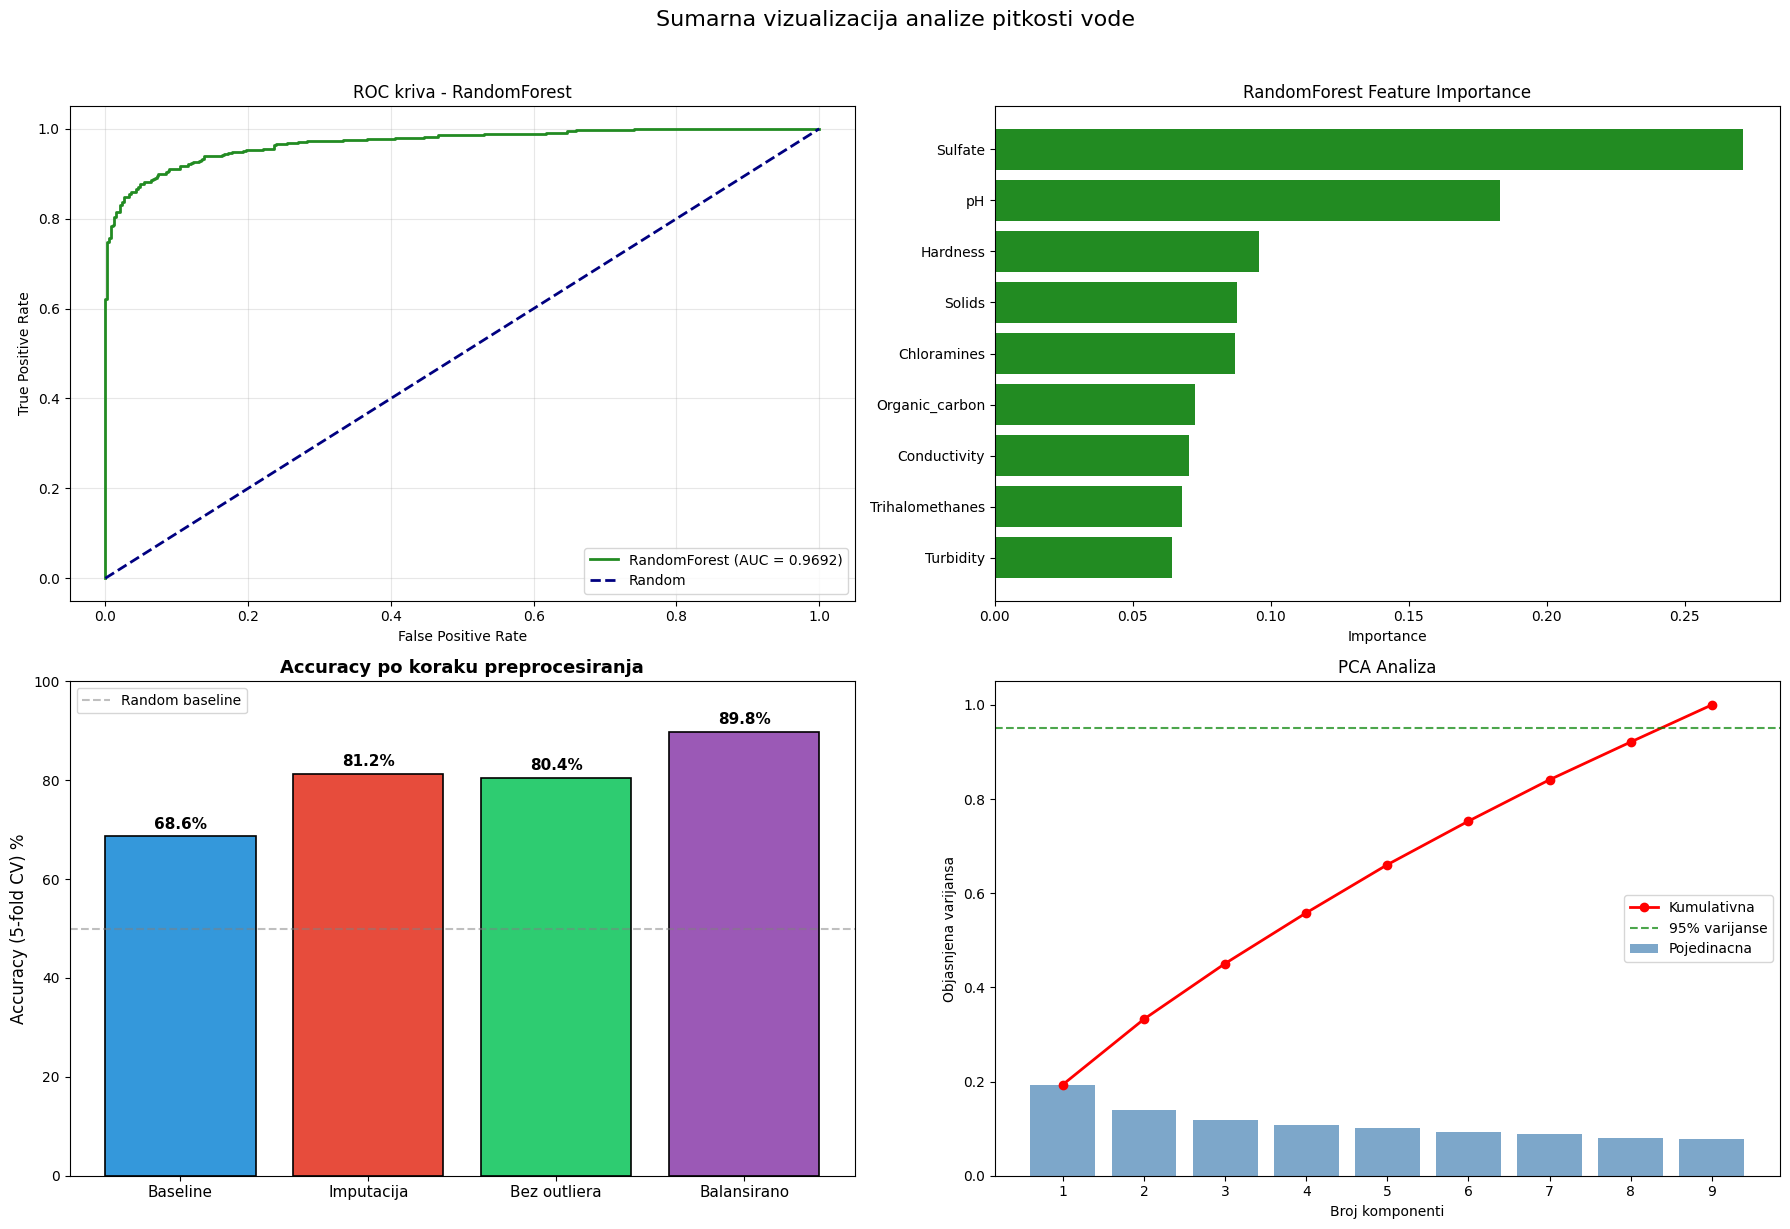

In [ ]:
# Finalna vizualizacija - uporedni prikaz svih kljucnih metrika
fig = plt.figure(figsize=(18, 12))

# 1. ROC krivulja - RandomForest
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(fpr, tpr, color='forestgreen', lw=2, label=f'RandomForest (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC kriva - RandomForest')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance 
ax2 = fig.add_subplot(2, 2, 2)
fi_sorted = rf_feature_importance.sort_values('importance', ascending=True)
ax2.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('RandomForest Feature Importance')

# 3. Accuracy po koracima preprocesiranja
ax3 = fig.add_subplot(2, 2, 3)
colors_acc = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
bars = ax3.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors_acc, edgecolor='black', linewidth=1.2)
ax3.set_xticks(range(len(summary_df)))
ax3.set_xticklabels(['Baseline', 'Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax3.set_ylabel('Accuracy (5-fold CV) %', fontsize=12)
ax3.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
ax3.legend()

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. PCA varijansa
ax4 = fig.add_subplot(2, 2, 4)
ax4.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
        pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', label='Pojedinacna')
ax4.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         'r-o', label='Kumulativna', linewidth=2)
ax4.axhline(y=0.95, color='g', linestyle='--', label='95% varijanse', alpha=0.7)
ax4.set_xlabel('Broj komponenti')
ax4.set_ylabel('Objasnjena varijansa')
ax4.set_title('PCA Analiza')
ax4.legend()
ax4.set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

plt.suptitle('Sumarna vizualizacija analize pitkosti vode', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
print("="*90)
print("FINALNI IZVESTAJ - KLASIFIKACIJA PITKOSTI VODE")
print("="*90)

print(f"""
DATASET:
  - Ukupan broj uzoraka: {len(df_original)}
  - Broj osobina: {len(features)}
  - Osobine: {', '.join(features)}

PREPROCESIRANJE:
  - Imputacija: Mean po grupama + KNN Imputer
  - Outlieri: Z-score metoda (prag=3)
  - Balansiranje: Upsampling manjinske klase

NAJBOLJI MODEL: RandomForest
  - Test Accuracy: {rf_accuracy:.4f}
  - AUC Score: {roc_auc_rf:.4f}
  - Optimizovani parametri: {rf_random_search.best_params_}

INTERPRETABILNOST:
  - SHAP i LIME analize uspesno sprovedene
  - Najvaznije osobine identifikovane konzistentno svim metodama

PCA ANALIZA:
  - Redukcija dimenzionalnosti NIJE preporucena
  - Sve osobine nose korisnu informaciju

POBOLJSANJE U ODNOSU NA BASELINE: {improvement_pct:.2f}%
""")
print("="*90)

FINALNI IZVESTAJ - KLASIFIKACIJA PITKOSTI VODE

DATASET:
  - Ukupan broj uzoraka: 3276
  - Broj osobina: 9
  - Osobine: pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity

PREPROCESIRANJE:
  - Imputacija: Mean po grupama + KNN Imputer
  - Outlieri: Z-score metoda (prag=3)
  - Balansiranje: Upsampling manjinske klase

NAJBOLJI MODEL: RandomForest
  - Test Accuracy: 0.8935
  - AUC Score: 0.9592
  - Optimizovani parametri: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 158}

INTERPRETABILNOST:
  - SHAP i LIME analize uspesno sprovedene
  - Najvaznije osobine identifikovane konzistentno svim metodama

PCA ANALIZA:
  - Redukcija dimenzionalnosti NIJE preporucena
  - Sve osobine nose korisnu informaciju

POBOLJSANJE U ODNOSU NA BASELINE: 32.91%

